# Modeling

In our first model before I go into feature selection, I'll quickly run a basic model. Since CRISP-DM is an iterative process, I'll start with this and then circle back as many times as necessary to get the results I'm looking for. I have split the data into 75% train and 25% test data for this model analysis.

In [1]:
#first import all the necessary libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
%matplotlib inline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#opening csv file as dataframe
df = pd.read_csv('house_sale_cleaned.csv')
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year,waterfront
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0.0,3,7,...,1955,0.0,98178,47.5112,-122.257,1340,5650,10,2014,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0.0,3,7,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,12,2014,0.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,0.0,3,6,...,1933,0.0,98028,47.7379,-122.233,2720,8062,2,2015,0.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0.0,5,7,...,1965,0.0,98136,47.5208,-122.393,1360,5000,12,2014,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0.0,3,8,...,1987,0.0,98074,47.6168,-122.045,1800,7503,2,2015,0.0


In [3]:
df.shape

(21247, 21)

In [4]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront'],
      dtype='object')

### Tools/Functions 


Since this is an iterative process I will initialy create a function for each iteration of code that I will need through out the coding.

In [5]:
def regress_plots(columns, model):
    
    '''
    Takes in a list of column names found in the DataFrame that is used in a statsmodel linear regression and 
    plots 4 Regression Plots for each variable to show residuals per variable.
    
    Parameters
    ----------
    columns:    (list) - List of column names belonging to DataFrame used in statsmodel linear regression model
    model:    (sm model) - a statsmodel linear regression model that contains the list of columns.
    
    Returns
    ----------
    A regress plot of all residuals for each column
    '''    
    for column in columns:
        fig = plt.figure(figsize=(15,8))
        fig = sm.graphics.plot_regress_exog(model, column, fig=fig)
        plt.show()

In [6]:
def qqplot(model):
    '''
    Takes in a StatsModel linear regression and plots a residual QQ Plot to check for normality and homoscedasticity.
    Parameters
    -------
    model:    (sm model) - a StatsModel fitted linear regression model
    Outputs
    --------
    A QQ Plot of the residuals to check for normality
    
    '''
    residuals = model.resid
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

In [7]:
def log_transform(df, column):
    
    '''
    Takes in a column name from the main data dataframe and creates 2 subplots showing histograms to compare 
    the differences between the original data and the log of that data.
    
    Parameters
    -----------
    df:    (DataFrame) - A DataFrame containing the columns being investigated
    column:    (str) - the column name of the data to be transformed
    
    Outputs
    ------------
    2 side-by-side subplots showing histograms of the original data and the log of that data
    '''
    
    plt.figure(figsize=(10,5))
    ax1 = plt.subplot(1, 2, 1)
    df[column].plot.hist(ax=ax1, edgecolor='black')
    ax1.set_title(f'{column}')
    
    column_log = np.log1p(abs(df[column]))
    ax2 = plt.subplot(1, 2, 2)
    plt.hist(column_log, edgecolor='black')
    ax2.set_title(f'Log of {column}')

In [8]:
def sk_linear_regression(df, predictors, outcome, log=False, 
                         random_seed=1234):
    
    '''
    Creates a linear regression model in Sci Kit Learn using a dataframe and defined predictors/outcomes 
    using a random split of train/test data. Analyzes the model and provides an R2 score, RMSE and MAE of the test
    and training data for comparison.
    Parameters
    -----------
    df:    (DataFrame) - a DataFrame containing test data for the regression
    predictors:    (list) - a list of columns of variables to be included in 
    outcome:    (str) - the string name of y variable column for the linear regression
    random_seed:    (int) - the value of the random seed used for the train/test split. Default = 1234
    log:    (bool) - Boolean determining if the outcome should be log transformed
    Returns
    -----------
    lr:    (LinearRegression()) - A Sci-Kit Learn linear regression model
    Metrics:   Prints a report of the Root Mean Squared Error, R2 Score and Absolute Mean Error for both test and train data
    Plot:    a plot of the residuals of the test and the train data for comparison next to a histogram of both data sets
    '''
    
    lr = LinearRegression()
    
    X = df[predictors]
    y = df[outcome]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        random_state=random_seed)
    
    if log == False:            
            y_train_final = y_train
            y_test_final = y_test
            
            lr.fit(X_train, y_train_final)

            y_train_pred = lr.predict(X_train)
            y_test_pred = lr.predict(X_test)
            
            y_train_pred_final = y_train_pred
            y_test_pred_final = y_test_pred
        
    else:
        y_train_final = np.log(y_train)
        y_test_final = np.log(y_test)

        lr.fit(X_train, y_train_final)

        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

        y_train_pred_final = np.exp(y_train_pred)
        y_test_pred_final = np.exp(y_test_pred)

      
    print("Training Scores:")
    print(f"R2: {r2_score(y_train_final, y_train_pred)}")

    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_train, y_train_pred_final))}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, y_train_pred_final)}")
    print("---")
    print("Testing Scores:")
    print(f"R2: {r2_score(y_test_final, y_test_pred)}")
    print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_test_pred_final))}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_test_pred_final)}")
            
    residuals_train = np.array(y_train_final) - np.array(y_train_pred)
    residuals_test = np.array(y_test_final) - np.array(y_test_pred)
    
    plt.figure(figsize=(15,5))
    
    ax1 = plt.subplot(1,2,1)
    
    plt.scatter(y_train_pred, residuals_train, color='yellow', alpha=.75)
    plt.scatter(y_test_pred, residuals_test, color='b', alpha=.75)

    plt.axhline(y=0, color='black')

    ax1.set_title('Residuals for Linear Regression Model')
    ax1.set_ylabel('Residuals')
    ax1.set_xlabel('Predicted Values')
    
    ax2 = plt.subplot(1,2,2)
    
    plt.hist(residuals_train, bins='auto', alpha=.75, color='yellow', edgecolor='y', label='Train')
    plt.hist(residuals_test, bins='auto', color='b', alpha=.75, edgecolor='y', label='Test')
    
    ax2.set_title('Histogram of Residuals')
    ax2.legend()
    
    plt.show()

    return lr

In [9]:
def sm_linear_regression(df, predictors, outcome, log = False, scaled = False,
                         random_seed = 1234):

    '''
    Creates a linear regression model in StatsModels using a dataframe and defined predictors/outcomes 
    using a random split of train/test data. Returns a model ready for summary.
    Parameters
    -----------
    df:    (DataFrame) - a DataFrame containing test data for the regression
    predictors:    (list) - a list of columns of variables to be included in 
    outcome:    (str) - the string name of y variable column for the linear regression
    random_seed:    (int) - the value of the random seed used for the train/test split. Default = 1234
    Returns
    -----------
    model:    (OLS) - A StatsModel linear regression model with a constant added
    '''
    
    X = df[predictors]
    y = df[outcome]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,
                                                        random_state=1066)
    
    if log == True:
        y_train = np.log(y_train)
    else:
        pass

    predictors_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, predictors_int).fit()
    
    return model


## Model #1: Base line 'Bad' Model

To begin I will establish a baseline with a model using both SKLearn and StatsModels. I will initially divide my data into 'continuous', 'categorical' and 'outcome' data. For the purpose of this model, categorical and continuous variables will both be treated as continuous except for the zipcode which I will deal with at the end for locational data model.

In [10]:
continuous = ['sqft_living','sqft_lot','yr_built','yr_renovated',
              'lat','long','sqft_living15','sqft_lot15','sqft_basement']
categorical = ['bedrooms', 'bathrooms', 'view', 'floors','waterfront',
               'condition','grade','month']
removed = ['id', 'year', 'zipcode']
outcome = ['price']

In [11]:
df.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront'],
      dtype='object')


I will use my sk_linear_regression function to produce my first model. It will also create a scatter plot of the model's residuals as well as a histogram of the test and train residuals for comparison.

Training Scores:
R2: 0.7133417677266007
Root Mean Squared Error: 146997.6006281257
Mean Absolute Error: 103903.66412833534
---
Testing Scores:
R2: 0.7071275289887794
Root Mean Squared Error: 150076.05938499796
Mean Absolute Error: 105372.0555716148


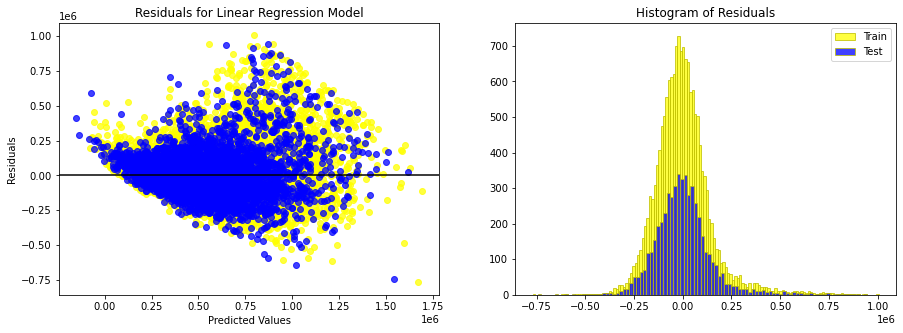

LinearRegression()

In [12]:
sk_linear_regression(df, continuous+categorical, outcome)

### Analysis

Taking note on the R2 score of 0.7133 for training data and 0.7071 for the test data our model can account for about 70.7% of the testing data's variance. Practicly speaking our outcome data would have an error of around $105372, which is a lot.
Moreover the test error has a higher value than the training error indicating an overfit model. This could use some work done on it. Also from the residuals plots, notice a strong heteroscedasticity creating a funnel like pattern.

Let's take a look at the Stats model summary below for more details.

In [13]:
model = sm_linear_regression(df, continuous+categorical, outcome)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     2335.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:17   Log-Likelihood:            -2.1208e+05
No. Observations:               15935   AIC:                         4.242e+05
Df Residuals:                   15917   BIC:                         4.243e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -2.98e+07   1.34e+06    -22.241      0.000   -3.24e+07   -2.72e+07
sqft_living      99.5292      3.257     30.561      0.000      93.146     105.913
sqft_lot          0.1858      0.041      4.543      0.000       0.106       0.266
yr_built      -2103.5323     60.816    -34.589      0.000   -2222.738   -1984.326
yr_renovated     21.7066      3.419      6.348      0.000      15.004      28.409
lat            5.432e+05   8785.503     61.824      0.000    5.26e+05     5.6e+05
long          -6.131e+04   1.01e+04     -6.074      0.000   -8.11e+04   -4.15e+04
sqft_living15    53.9928      2.986     18.084      0.000      48.141      59.845
sqft_lot15       -0.1963      0.060     -3.268      0.001      -0.314      -0.079
sqft_basement    -5.2140      3.725     -1.400      0.162     -12.515       2.087
bedrooms      -1.835e+04   1704.191    -10.767      0.000   -2.17e+04    -1.5e+04
bathrooms      3.286e+04   2799.064     11.741      0.000    2.74e+04    3.84e+04
view           4.043e+04   1834.766     22.037      0.000    3.68e+04     4.4e+04
floors         2.706e+04   3022.605      8.951      0.000    2.11e+04     3.3e+04
waterfront     2.017e+05    1.7e+04     11.864      0.000    1.68e+05    2.35e+05
condition      3.205e+04   1958.550     16.364      0.000    2.82e+04    3.59e+04
grade          8.891e+04   1844.876     48.193      0.000    8.53e+04    9.25e+04
month         -2656.6729    372.655     -7.129      0.000   -3387.119   -1926.227
==============================================================================
Omnibus:                     4044.263   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17803.306
Skew:                           1.180   Prob(JB):                         0.00
Kurtosis:                       7.609   Cond. No.                     5.70e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see from our model summary that the distribution is moderatly skewed with a Skew value of 1.180 which is not very high. This could mean that our data has outliers affecting the distortion from the normal distribution.
Also the Kurtosis value of 7.609 tells us that the data has longer and fatter tails indicating that the majority of the data appears in a narrow vartical line and the heavy tails indicate more outliers. The JB value of 17,803 indicates that errors are not normally distributed.


### Baseline Analysis and Plan of Action

From this basic model we can perceive that the sqft_basement has a 16% chance that it may not affect our outcome. The summary also provides a note warning there may be a strong multicollinearity in our model.

Although our R2 does seem to be OK, it doesn't necessarily indicate a good model when considered with all the above factors. So our next step would be to transform those variables whose residuals are affecting our model's performance. In the QQ plot below we can notice the outliers affecting the normality of the distribution. Now in order to identify what transformation would be useful we will begin by analysing the model's residuals.

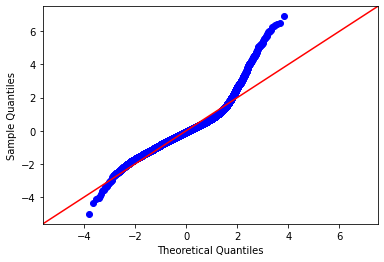

In [14]:
qqplot(model)


In order to determine the next steps of the process, we need to look at how each variable performed within the first model. Below you can see the regression plot showing residual analysis for the continuous variables.

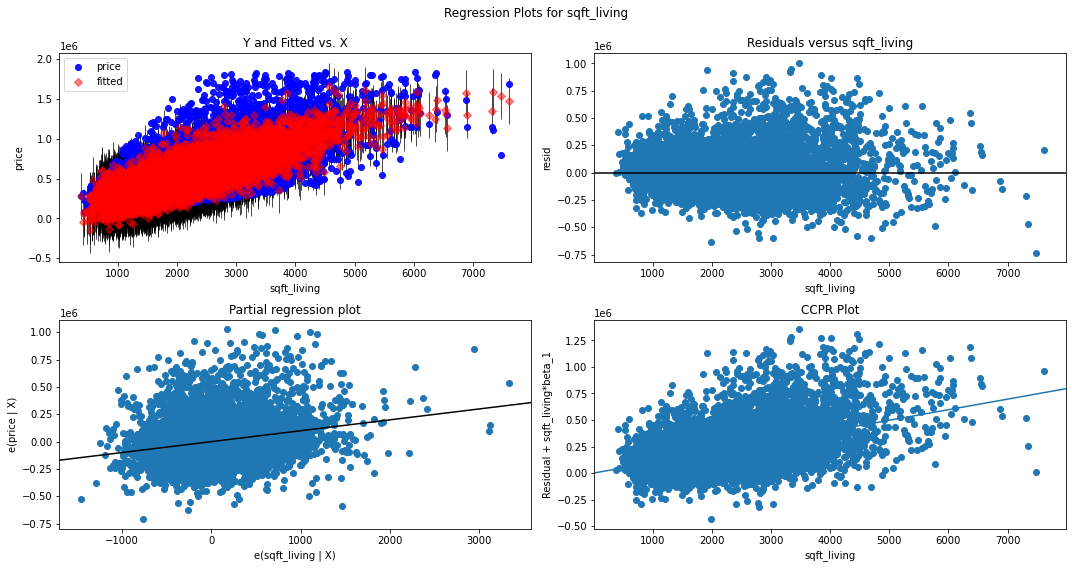

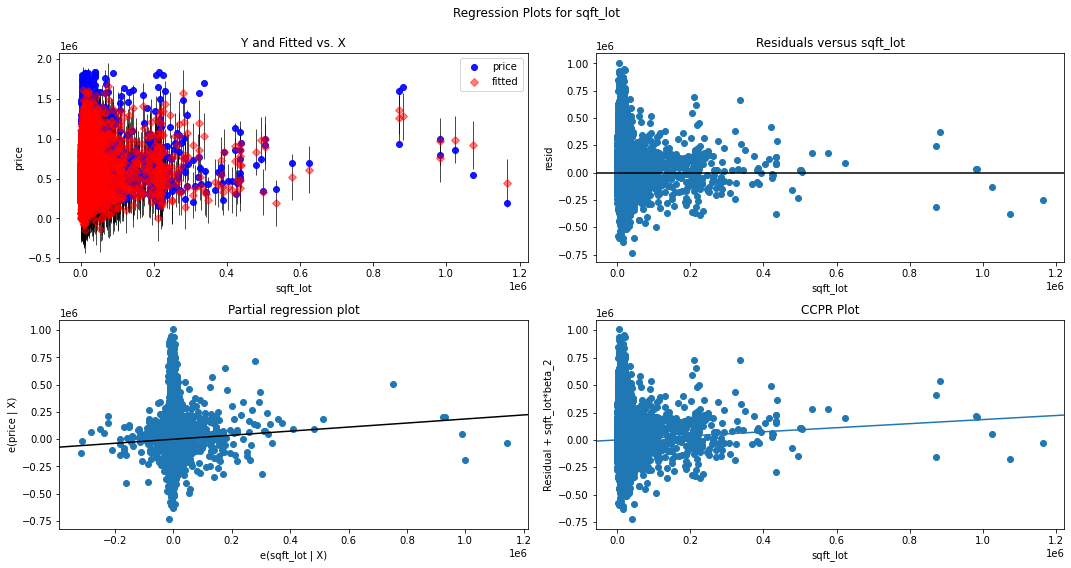

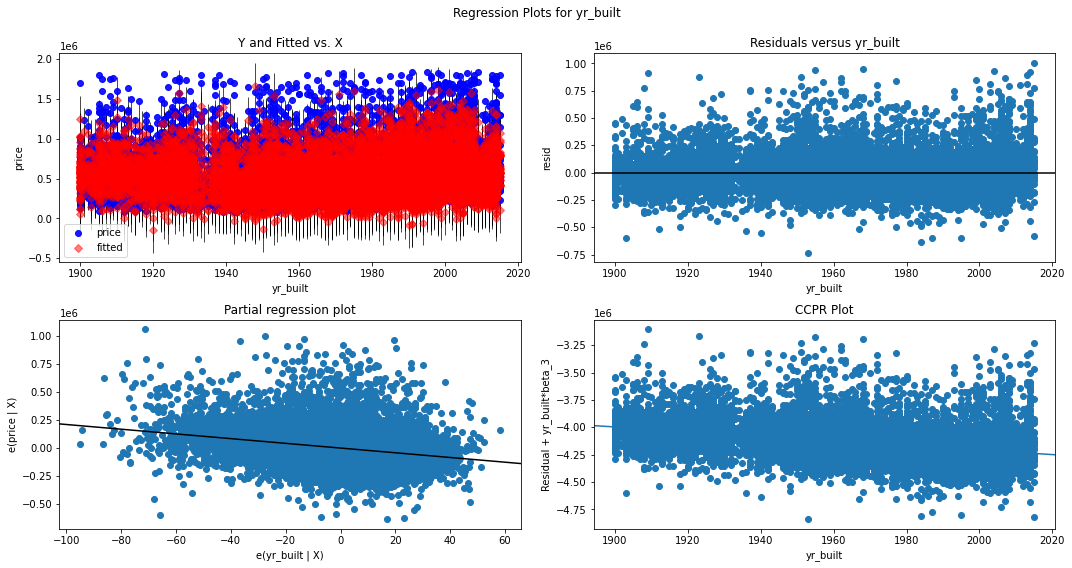

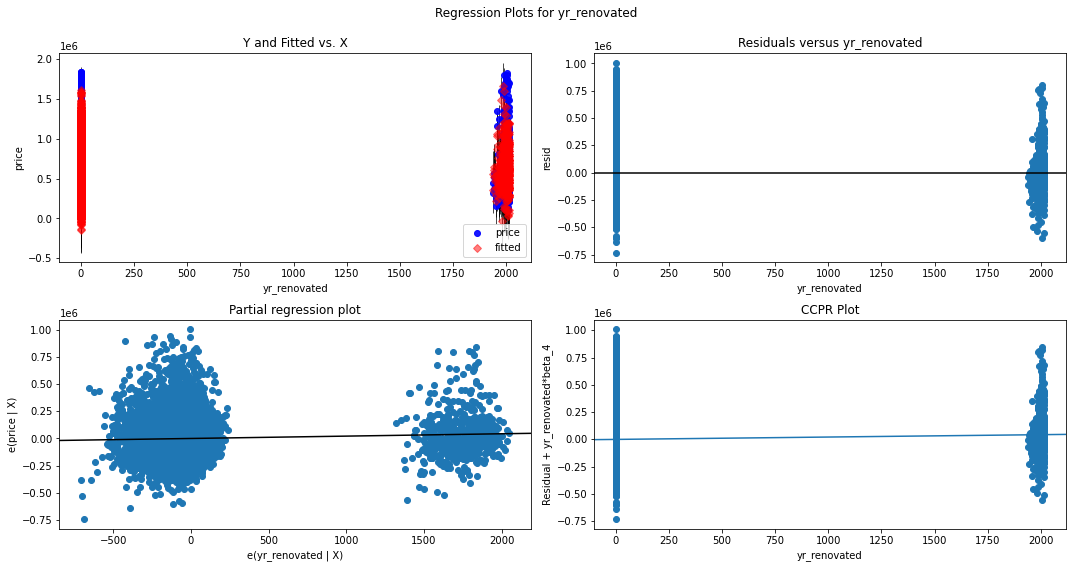

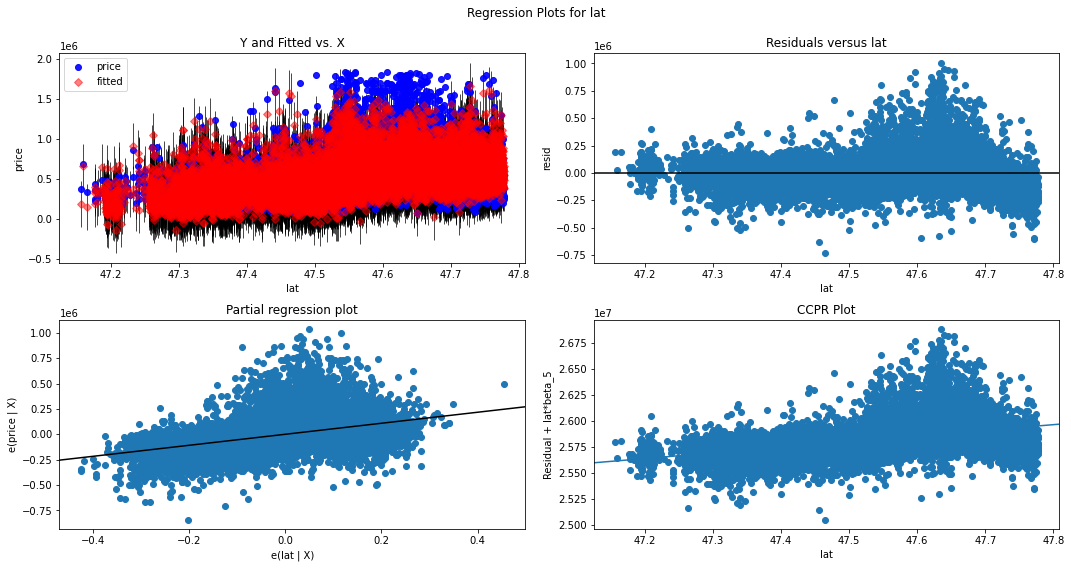

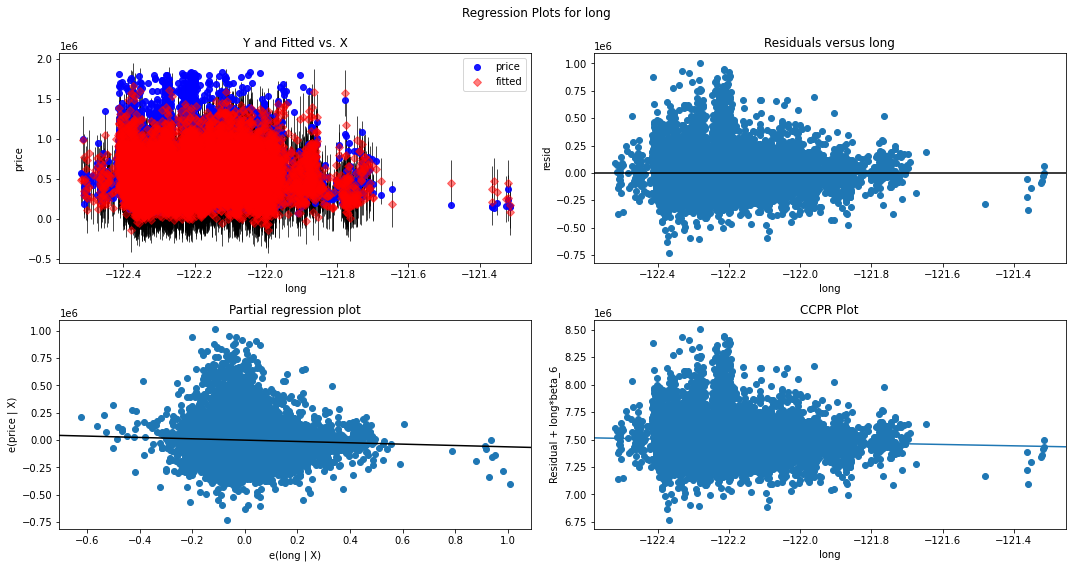

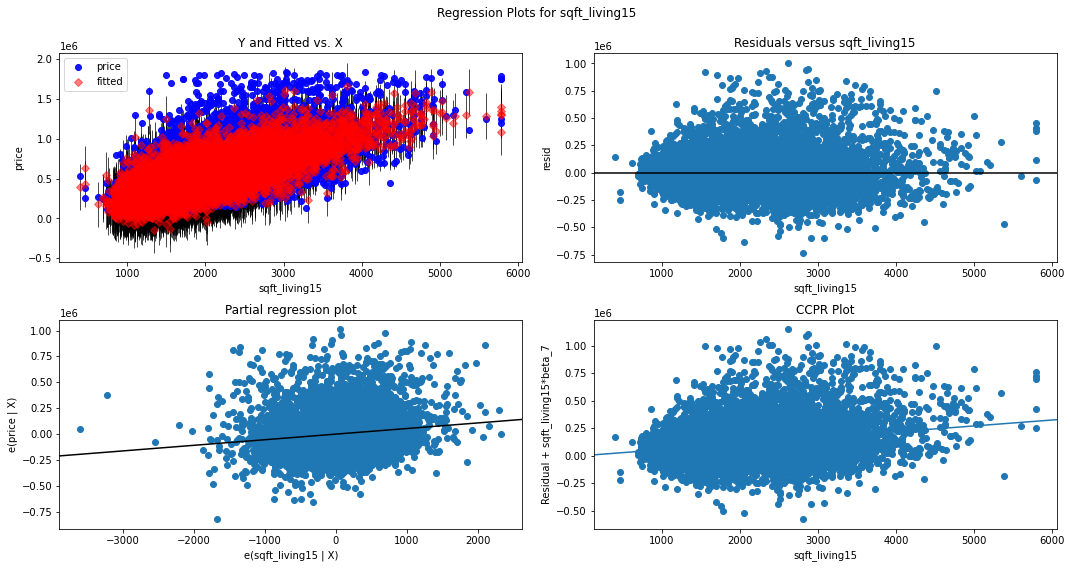

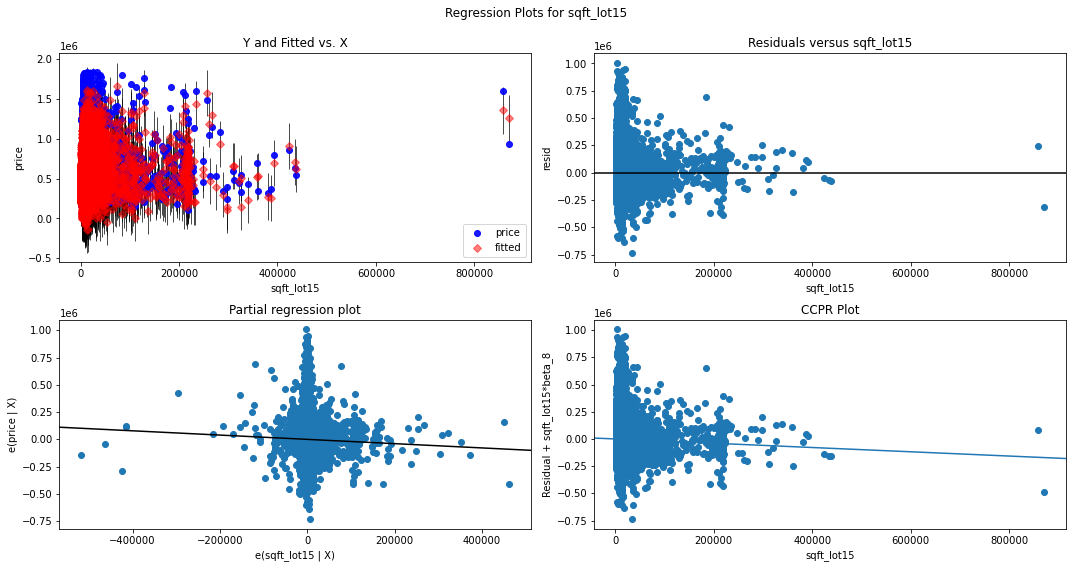

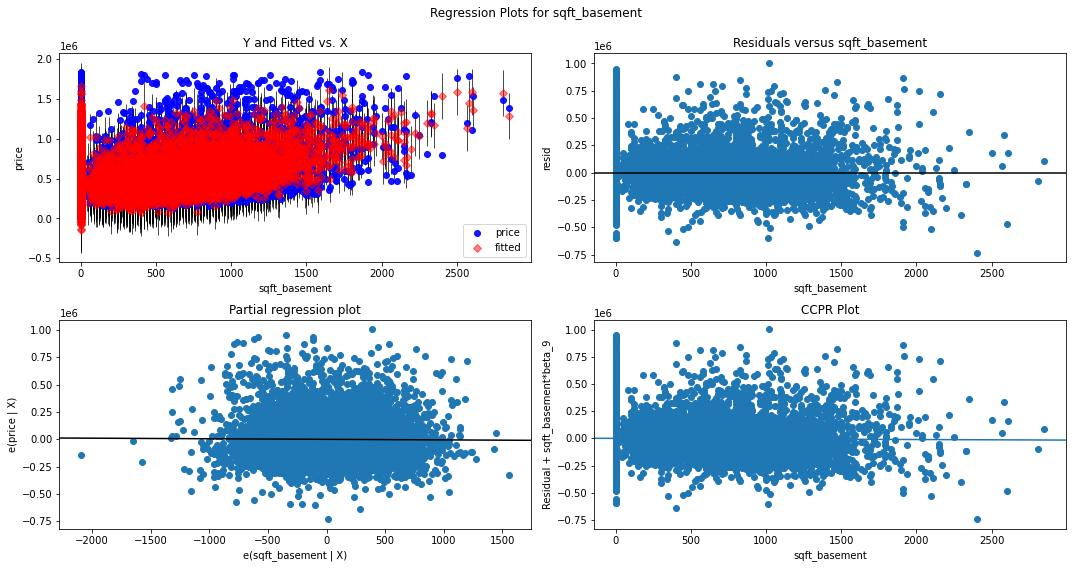

In [15]:
regress_plots(continuous,model)

As we can see, there is a strong case that the sqft_living variable is heteroscedastic and will throw off our model considerably. One of the possible causes is that, as housing price increases, it follows a logarithmic pattern. The first possible remedy is to log transform some of the variables to see if the outliers reduce their influence. Below you can see the histogram of the sqft_living variable and the price outcome variable next to the log transformation of that data:

The hetroscedasticity of some of the variables is observable and will throw off our model greatly. One of the possible causes is that as the Price increases some of the variables follow a logarithmic pattern. Hence, coming to our first fix to be the log transformation of those variables including the price to see if the outliers would reduce thier influence. Below is a sample histogram of sqft_living and log transformation of that data.

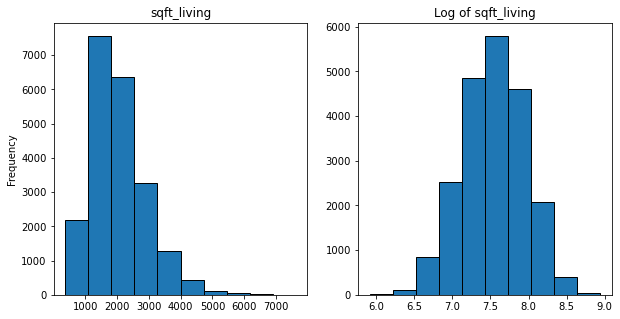

In [16]:
log_transform(df,'sqft_living')

And if we apply the same transformation to the Price column, we can see that it takes a heavily skewed dataset and gives it a greater degree of normalcy.

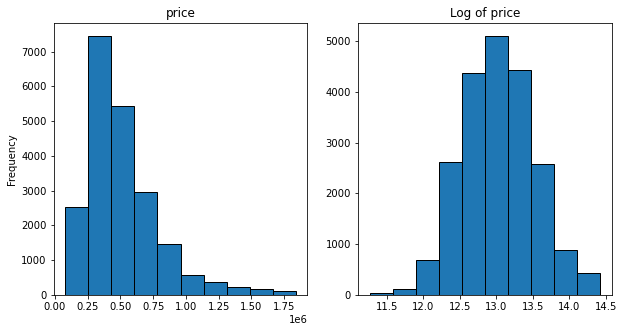

In [17]:
log_transform(df, 'price')


## Model #2: Log Transformations

The log transformation of the continuous variables should make the data distribution far more normal than is was, while also handling the outliers effectively.  Now in this next step we will observe how the log transformations of each of those variables affect the distribution.

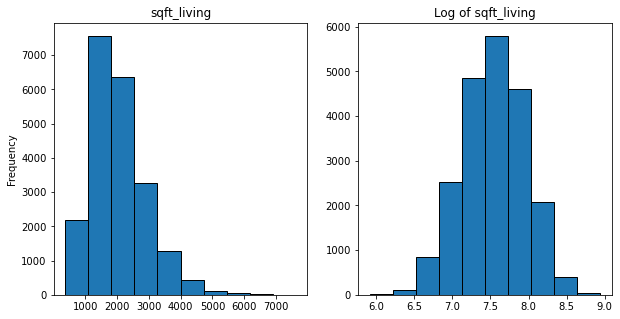

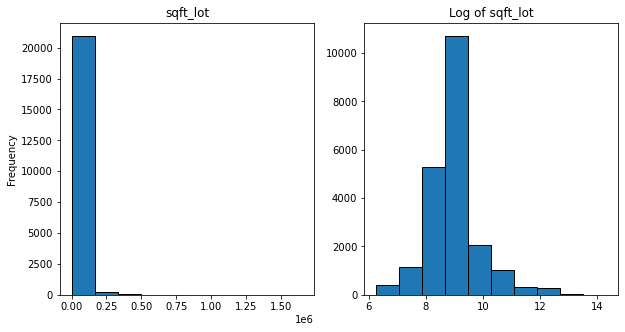

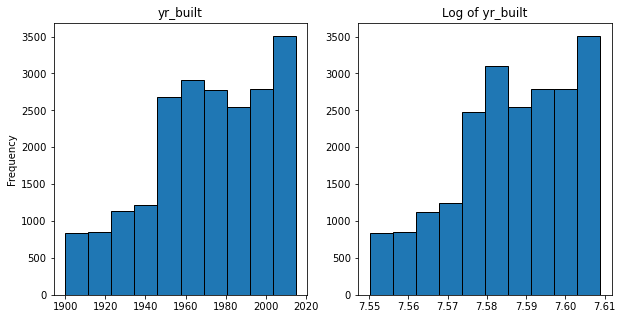

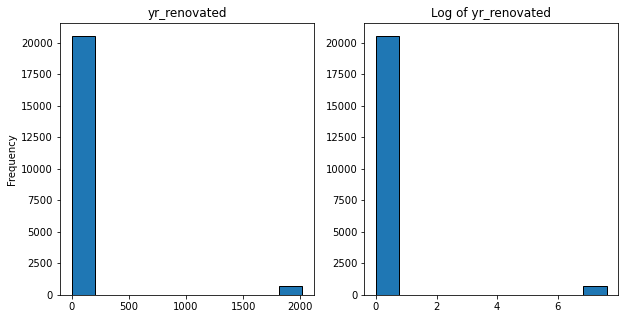

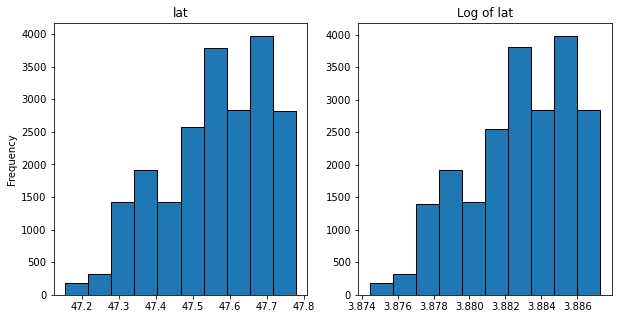

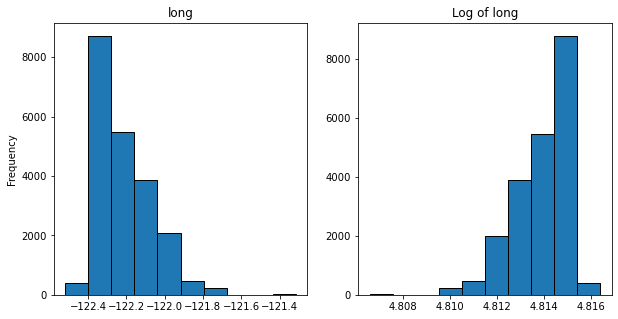

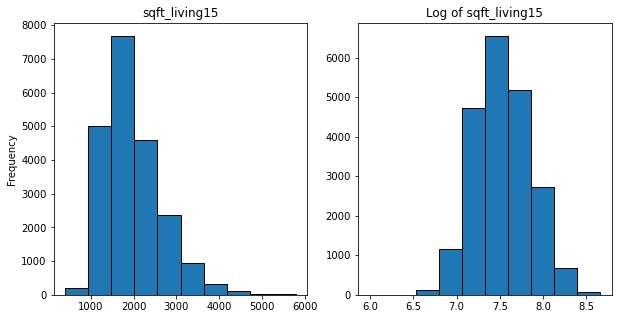

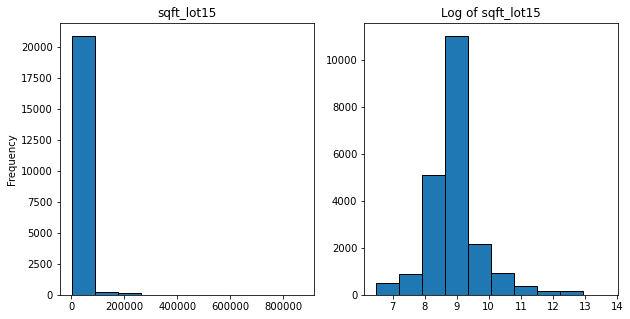

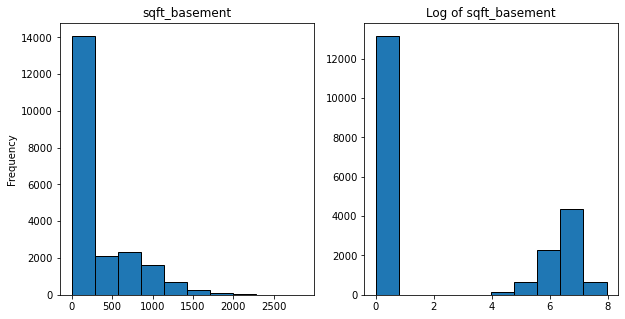

In [18]:
for column in continuous:
    log_transform(df, column)

Although with some skewness and higher kurtosis the following variables have adapted a normal distribution after transformation.

- Sqft_living
- Sqft_lot
- Sqft_living15
- Sqft_lot15
- Price


If we apply these log transformations to our model we will see if that increases our accuracy. We will not transform 'Price' at the moment, but it will be transformed in the function sk_linear_regression and then inverted in order to evaluate the Mean Absolute Error and Root Mean Squared Error scores.

In [19]:
log_cols = ['sqft_living','sqft_lot','sqft_living15','sqft_lot15']

logs = []

for x in log_cols:
    df[f'{x}_log'] = np.log(df[x])
    logs.append(f'{x}_log')
    
df_log = df.drop(columns=log_cols)

In [20]:
continuous = ['yr_built', 'yr_renovated', 'lat', 'long', 'sqft_basement']
outcome = 'price'


Training Scores:
R2: 0.7512672809039933
Root Mean Squared Error: 147216.6090196566
Mean Absolute Error: 98347.2828498151
---
Testing Scores:
R2: 0.745967230068763
Root Mean Squared Error: 149835.73679855873
Mean Absolute Error: 100015.13522260991


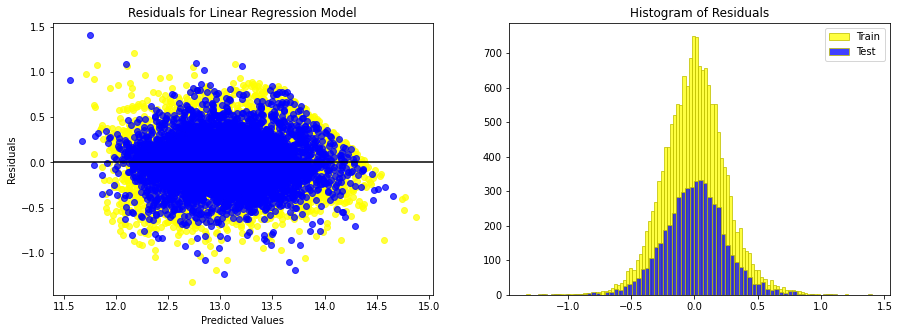

LinearRegression()

In [21]:
sk_linear_regression(df_log, continuous+logs+categorical, outcome, log=True)

### Analysis

For our second model, we can account for 74.6% of the data's variance. The model is starting to look like a good fit since our test scores and train scores vary only slightly(by 0.02%). Our outcome data would have an error of around $100,015 which is still a lot to accurately determine the price of a property but atleast since it is lower than it was, we know we are on the right track. In the residuals plot the issue of heteroscedasticity seems to have been resolve for the moment.

Let's take a look at the Stats model summary below for more details.

In [22]:
model = sm_linear_regression(df, continuous+logs+categorical, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     2780.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:34   Log-Likelihood:                -293.39
No. Observations:               15935   AIC:                             622.8
Df Residuals:                   15917   BIC:                             761.0
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -44.6526      2.357    -18.946      0.000     -49.272     -40.033
yr_built             -0.0035      0.000    -34.233      0.000      -0.004      -0.003
yr_renovated       3.131e-05   5.78e-06      5.414      0.000       2e-05    4.26e-05
lat                   1.3163      0.015     88.010      0.000       1.287       1.346
long                  0.0291      0.017      1.663      0.096      -0.005       0.063
sqft_basement      2.935e-06   6.39e-06      0.459      0.646   -9.59e-06    1.55e-05
sqft_living_log       0.3296      0.012     28.103      0.000       0.307       0.353
sqft_lot_log          0.0174      0.006      3.026      0.002       0.006       0.029
sqft_living15_log     0.2392      0.010     23.575      0.000       0.219       0.259
sqft_lot15_log       -0.0455      0.006     -7.272      0.000      -0.058      -0.033
bedrooms             -0.0271      0.003     -9.122      0.000      -0.033      -0.021
bathrooms             0.0605      0.005     12.757      0.000       0.051       0.070
view                  0.0604      0.003     19.508      0.000       0.054       0.066
floors                0.0560      0.006     10.136      0.000       0.045       0.067
waterfront            0.2729      0.029      9.476      0.000       0.216       0.329
condition             0.0646      0.003     19.463      0.000       0.058       0.071
grade                 0.1556      0.003     51.740      0.000       0.150       0.161
month                -0.0050      0.001     -7.888      0.000      -0.006      -0.004
==============================================================================
Omnibus:                      251.518   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              491.671
Skew:                           0.030   Prob(JB):                    1.72e-107
Kurtosis:                       3.858   Cond. No.                     2.41e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.41e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Log transform Analysis and Plan of Action

From our model summary we observe an appreciable improvement in the skewness, kurtosis and R-squared. Although sqft_basement continue to resist its effect on the outcome to be of paramount significance, we could look into it more. Also in the note part of the summary we see that we still have a high chance that there is multicollinearity and must investigate variable interactions. Finally, if we check the QQplot of the model's residuals, we can see a marked upgrade over what we had before. The residuals aren't perfect yet, but we can improve on them.

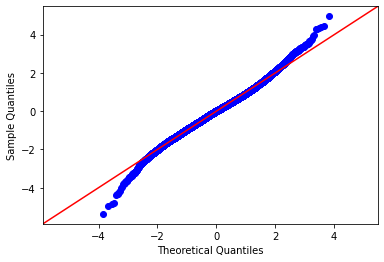

In [23]:
qqplot(model)


And let's take another look at our log transformed variables in the following regression plot. As you can see, we've removed majority of the heteroscedasticity and the residuals for those variable are starting look more normally distributed.

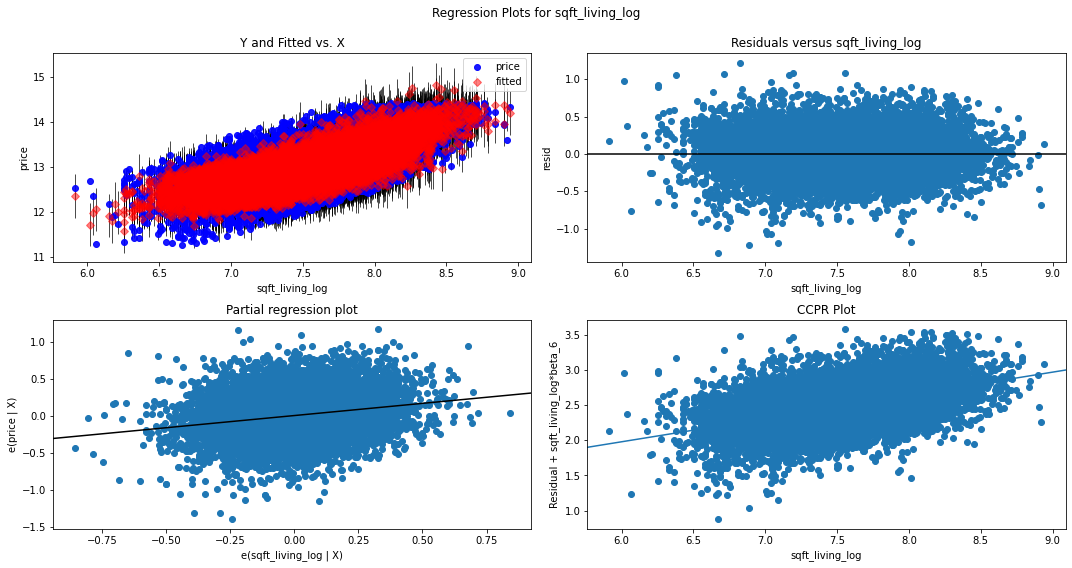

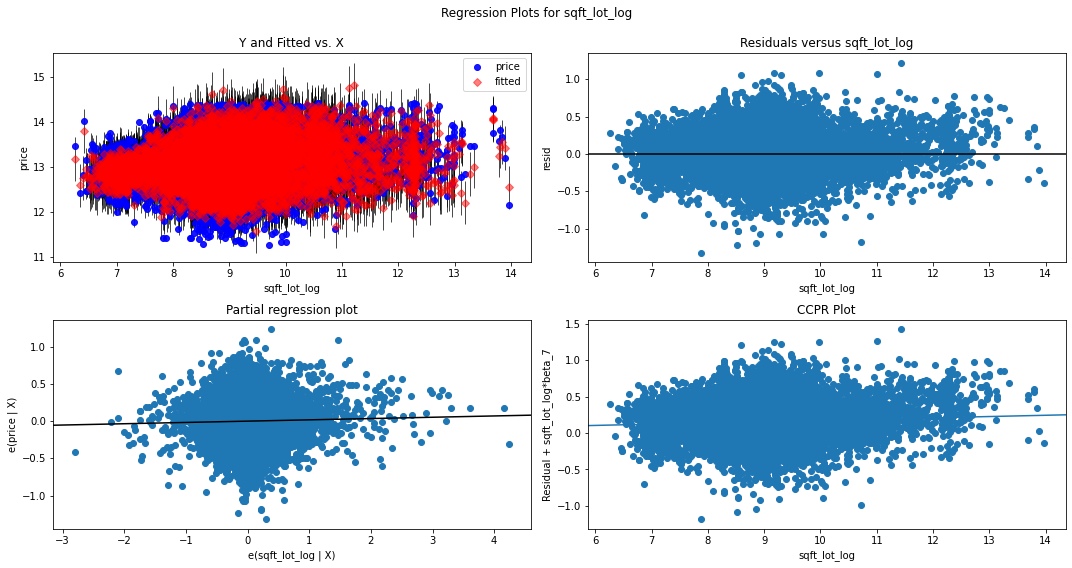

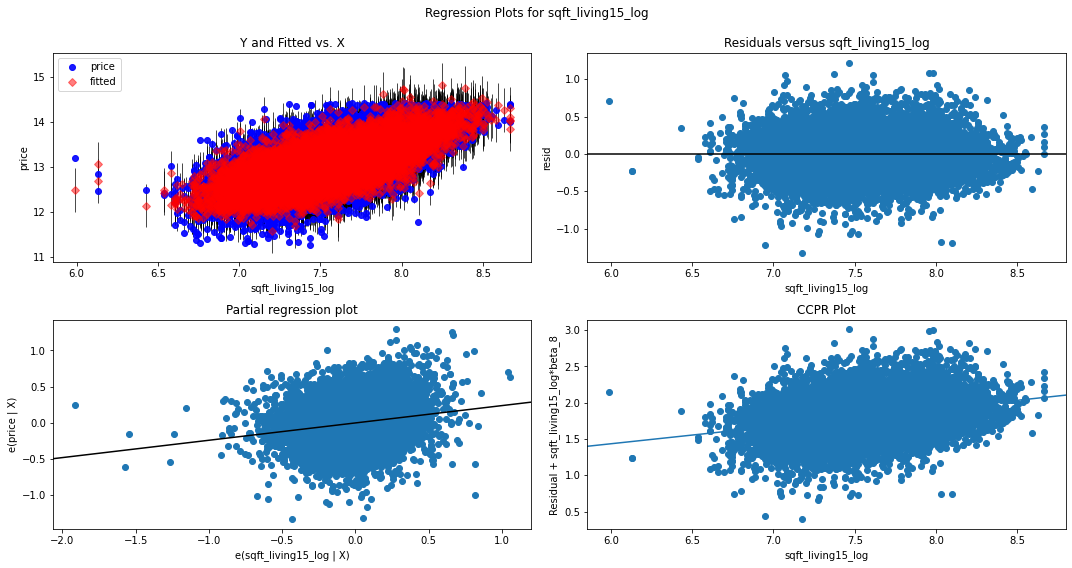

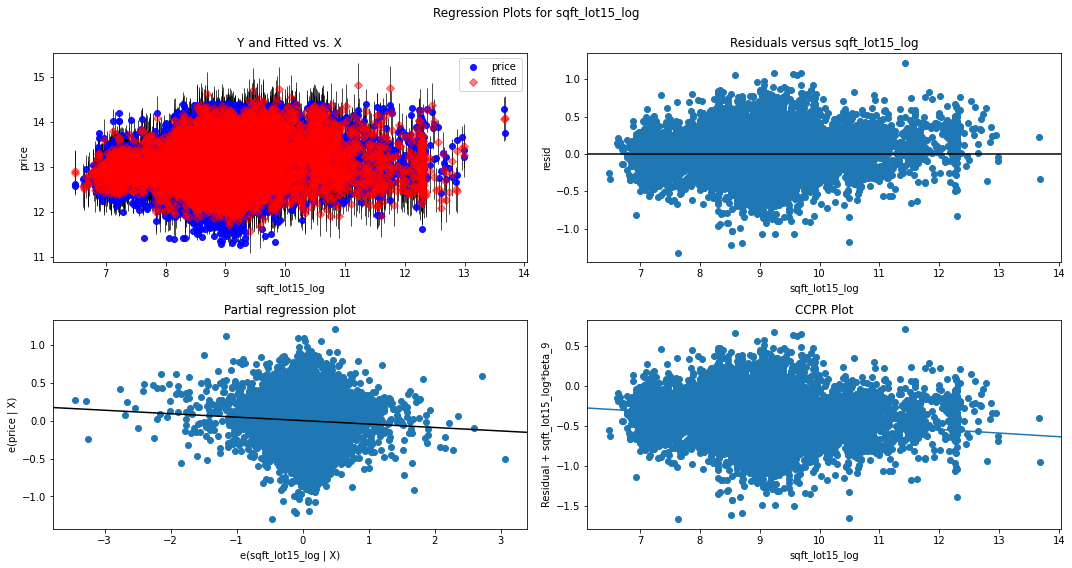

In [24]:
regress_plots(logs, model)

In the next model I will go into more details to explore the categorical variables as well.

## Model #3: One Hot Encoding Categoricals

In our previous models I was only using the continuous data and not the categorical. For this section I will be using one-hot-encoding our categoricals to make sure they are read into the model accurately. I have picked out the following variables to follow a categorical pattern:

- bedrooms
- bathrooms
- floors
- waterfront
- condition
- grade

Before going into it though I will investigate if each variable needs to be preprocessed first. Here is a break down of each variable.

In [25]:
for x in categorical:
    print(f'{x} has {df[x].nunique()} unique values')

bedrooms has 8 unique values
bathrooms has 25 unique values
view has 5 unique values
floors has 6 unique values
waterfront has 2 unique values
condition has 5 unique values
grade has 11 unique values
month has 12 unique values


As we can see above, zipcode, month and grade would have high number of categories and hence resulting in a huge number of columns to the dataframe. So I will drop the zipcode for now and use it later for exploring more on the locational aspect of the model.

Here is a review of our current variable breakdown.

In [26]:
print('Continuous columns: ', continuous)
print('Categorical columns: ', categorical)
print('Log Transformed columns: ', logs)
print('Outcome column: ', outcome)

Continuous columns:  ['yr_built', 'yr_renovated', 'lat', 'long', 'sqft_basement']
Categorical columns:  ['bedrooms', 'bathrooms', 'view', 'floors', 'waterfront', 'condition', 'grade', 'month']
Log Transformed columns:  ['sqft_living_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log']
Outcome column:  price


For this business program we are more interested in homes for single family and I am going to assume that our Real estate agency will not be interested in houses not renovated for more than 10 years. So I will create a new column 'Recent_Const' that takes in a boolean value and returns 'True' for houses built or renovated after 2005.


In [27]:
df['Recent_Const'] = False
df['Recent_Const'] = df.loc[(df.yr_built >= 2005) | (df.yr_renovated >= 2005)
                           ].Recent_Const.map(lambda x: True)
df.Recent_Const.fillna(False,inplace=True)
categorical.append('Recent_Const')
continuous.remove('yr_built')
continuous.remove('yr_renovated')


We can now One Hot Encode the following columns while dropping the first column to ensure we don't cause any further multicollinearity. We will build these new columns using the Pandas get_dummies function.

In [28]:
cat_df = []

for column in categorical:
    cat_df.append(pd.get_dummies(df[column], prefix=column, drop_first=True))

ohe_df = pd.concat(cat_df, axis=1)

ohe_cols = ohe_df.columns.to_list()

df_ohe1 = pd.concat([df, ohe_df], axis=1)


Now that we have those categorical variables one hot encoded we can see how this transformation has affected our model.

Training Scores:
R2: 0.7418672584235038
Root Mean Squared Error: 149021.9457459874
Mean Absolute Error: 100740.63119011057
---
Testing Scores:
R2: 0.7340130639704007
Root Mean Squared Error: 152919.83942899364
Mean Absolute Error: 103030.8270952342


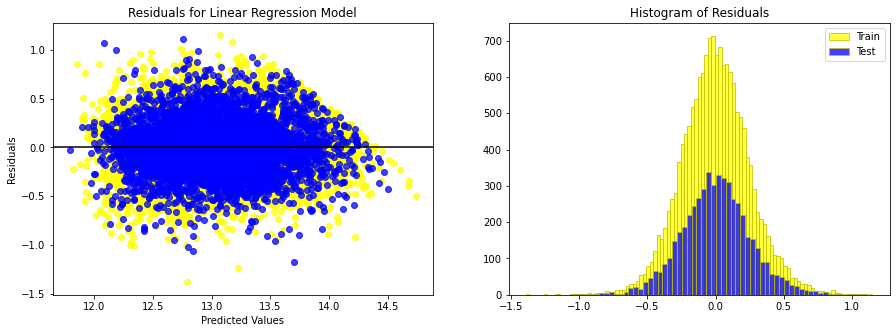

LinearRegression()

In [29]:
predictors = continuous + ohe_cols + logs
sk_linear_regression(df_ohe1, predictors, outcome, log=True)

### Analysis

Taking a look at how our 3rd model performed, we can account for 73.4% of the data's variance. Model looks slightly over fit with higher test score and train scores. Our data would have an error of around $103,030 which is a little more than our last model but we could still do better. Homoscedastcity is visible in the spread of the residuals.

Let's take a look at the Stats model summary below for more details.

In [30]:
model = sm_linear_regression(df_ohe1, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     604.2
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:41   Log-Likelihood:                -599.22
No. Observations:               15935   AIC:                             1348.
Df Residuals:                   15860   BIC:                             1924.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -73.5375      2.246    -32.748      0.000     -77.939     -69.136
lat                   1.4036      0.015     92.541      0.000       1.374       1.433
long                 -0.1247      0.017     -7.196      0.000      -0.159      -0.091
sqft_basement       6.67e-06   6.81e-06      0.980      0.327   -6.67e-06       2e-05
bedrooms_2           -0.0316      0.022     -1.417      0.156      -0.075       0.012
bedrooms_3           -0.0956      0.022     -4.250      0.000      -0.140      -0.052
bedrooms_4           -0.1107      0.023     -4.791      0.000      -0.156      -0.065
bedrooms_5           -0.1305      0.024     -5.361      0.000      -0.178      -0.083
bedrooms_6           -0.1210      0.030     -4.029      0.000      -0.180      -0.062
bedrooms_7           -0.2364      0.059     -3.988      0.000      -0.353      -0.120
bedrooms_8           -0.0703      0.088     -0.800      0.424      -0.243       0.102
bathrooms_0.75        0.3620      0.150      2.409      0.016       0.068       0.657
bathrooms_1.0         0.3426      0.146      2.351      0.019       0.057       0.628
bathrooms_1.25        0.2949      0.179      1.651      0.099      -0.055       0.645
bathrooms_1.5         0.3238      0.146      2.220      0.026       0.038       0.610
bathrooms_1.75        0.3431      0.146      2.353      0.019       0.057       0.629
bathrooms_2.0         0.3565      0.146      2.444      0.015       0.071       0.642
bathrooms_2.25        0.3378      0.146      2.316      0.021       0.052       0.624
bathrooms_2.5         0.3155      0.146      2.163      0.031       0.030       0.601
bathrooms_2.75        0.3484      0.146      2.386      0.017       0.062       0.635
bathrooms_3.0         0.3725      0.146      2.548      0.011       0.086       0.659
bathrooms_3.25        0.4011      0.146      2.739      0.006       0.114       0.688
bathrooms_3.5         0.4080      0.146      2.788      0.005       0.121       0.695
bathrooms_3.75        0.4775      0.148      3.224      0.001       0.187       0.768
bathrooms_4.0         0.4402      0.149      2.962      0.003       0.149       0.732
bathrooms_4.25        0.4547      0.151      3.012      0.003       0.159       0.751
bathrooms_4.5         0.4626      0.150      3.087      0.002       0.169       0.756
bathrooms_4.75        0.4579      0.179      2.559      0.010       0.107       0.809
bathrooms_5.0         0.5227      0.161      3.242      0.001       0.207       0.839
bathrooms_5.25        0.4800      0.193      2.481      0.013       0.101       0.859
bathrooms_5.5         0.5395      0.207      2.604      0.009       0.133       0.946
bathrooms_5.75       -0.0933      0.297     -0.314      0.753      -0.675       0.488
bathrooms_6.0         0.4084      0.295      1.383      0.167      -0.171

### One Hot Encoding Analysis and Plan of Action

We can see that our data distribution is fairly normal at this point and the kurtosis hasn't changed much but is still close to a normal distribution with less extreme values. However, we need to reassess this current categorical set up (and drop the 'sqft_basement') because, as we can see from the summary, there are a number of variables with a p value greater than our alpha of 0.05, meaning we cannot reject the null hypothesis that they have zero effect on the outcome(price). This is a good indication that our categorical variables need some help.
Finally, if we check the QQplot of the model the residuals aren't perfect yet, notably need some more work.

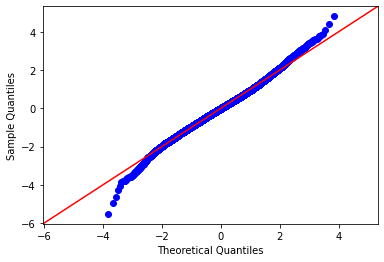

In [31]:
qqplot(model)


That's looking a little better! While our model isn't any more accurate, we are getting closer. We're going to reassess those categoricals next. Let's drop 'sqft_basement' from our continuous variables before moving on to the next step.

In [32]:
continuous = ['lat', 'long']

## Model #4: Bining categorical variables

In the previous model the categorical variables have outnumbered our continous variables. Since this could affect our model's performance I will try and consider binning some of the categorical variables to reduce the number of columns. I will deal with zipcode in the next model for locational data modeling.

For each column in the categorical list I will create bins with the following specifications. Values below the median will be assigned as 'Low', values above the median will be labeled as 'High' and the median itself will be assigned 'Medium'. The whole purpose of this is to weigh our data in such a manner that it doesn't disturb the normality of the distribution. A statistical description of the columns will be our bench mark to determine our boundaries for our bins.

In [33]:
df[categorical].describe()

,bedrooms,bathrooms,view,floors,waterfront,condition,grade,month
count,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000,21247.000000
mean,3.356568,2.094190,0.212171,1.489034,0.005130,3.408622,7.620229,6.577682
std,0.886866,0.740771,0.721163,0.538827,0.071443,0.649489,1.125652,3.113449
min,1.000000,0.500000,0.000000,1.000000,0.000000,1.000000,3.000000,1.000000
25%,3.000000,1.500000,0.000000,1.000000,0.000000,3.000000,7.000000,4.000000
50%,3.000000,2.250000,0.000000,1.500000,0.000000,3.000000,7.000000,6.000000
75%,4.000000,2.500000,0.000000,2.000000,0.000000,4.000000,8.000000,9.000000
max,8.000000,6.750000,4.000000,3.500000,1.000000,5.000000,13.000000,12.000000


Another point I would want to make is, considering we are dealing with only single family houses, I will only examine houses which satisfy the standard bathrooms per bedroom being 2 to 3. So for this analysis I will exclude houses with less than 1 bathroom. May be this could have had something to do with our outliers in the QQ plot. 


We will see.


In [34]:
df.shape

(21247, 26)

In [35]:
#consider houses with one or more bathrooms
df = df.loc[df['bathrooms'] >= 1]

From our categories 'view' doesn't seem to be feasible for transforming into a continous variable. Also we will not need to process waterfront since it is a boolean value.

In [36]:
df.shape

(21172, 26)

We can see we have dropped 75 rows, which is ok since it is small compared to our data.


Based on this breakdown, the mid-range of each variable would be:

- Bedrooms       - 3-4 bedrooms
- Bathrooms      - 1.5-2.5 bathrooms
- Condition      - 3-4
- Grade          - 7-8
- yrs_reno  - 10 years


- **Floors**
* 1-1.5 Floors = Small
* 2-2.5 Floors = Medium
* 3+ Floors = Big

Just to review our categorical and continuous list again:

In [37]:
continuous

['lat', 'long']

In [38]:
categorical

['bedrooms',
 'bathrooms',
 'view',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'month',
 'Recent_Const']

In [39]:
df[categorical].describe()

,bedrooms,bathrooms,view,floors,waterfront,condition,grade,month
count,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000,21172.000000
mean,3.361657,2.098999,0.211553,1.490459,0.004912,3.408417,7.627149,6.577839
std,0.882813,0.737647,0.720013,0.539042,0.069916,0.648715,1.119743,3.113057
min,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,4.000000,1.000000
25%,3.000000,1.750000,0.000000,1.000000,0.000000,3.000000,7.000000,4.000000
50%,3.000000,2.250000,0.000000,1.500000,0.000000,3.000000,7.000000,6.000000
75%,4.000000,2.500000,0.000000,2.000000,0.000000,4.000000,8.000000,9.000000
max,8.000000,6.750000,4.000000,3.500000,1.000000,5.000000,13.000000,12.000000


In [40]:
def floors(value):
    
    if value <= 1.5:
        return 'SML'
    elif 2 <= value <= 2.5:
        return 'MED'
    else:
        return 'BIG'

In [41]:
df['Building'] = df.floors.map(lambda x: floors(x))
df.Building.value_counts()

SML    12410
MED     8153
BIG      609
Name: Building, dtype: int64

In [42]:
def bathrooms(value):
    if value <= 2.25:
        return 'Low'
    elif value == 2.5:
        return 'Med'
    else:
        return 'High'

In [43]:
df['Baths'] = df.bathrooms.map(lambda x: bathrooms(x))
df.Baths.value_counts()

Low     12273
Med      5334
High     3565
Name: Baths, dtype: int64

In [44]:
def bedrooms(value):
    if value < 3:
        return 'Small'
    elif  value == 3:
        return 'Medium'
    else:
        return 'Large'

In [45]:
df['Beds'] = df.bedrooms.map(lambda x: bedrooms(x))
df.Beds.value_counts()

Medium    9732
Large     8549
Small     2891
Name: Beds, dtype: int64

In [46]:
def condition(value):
    if value < 2:
        return ' Very Bad'
    elif value == 2:
        return 'Bad'
    elif value > 3:
        return 'Good'

In [47]:
df['Cond'] = df.condition.map(lambda x: condition(x))
df.Cond.value_counts()

Good         7218
Bad           164
 Very Bad      28
Name: Cond, dtype: int64

In [48]:
def grade(value):
    if value < 7:
        return 'Very Bad'
    elif 7 <= value <= 8:
        return 'Bad'
    elif value > 8:
        return 'Good'

In [49]:
df['Grade'] = df.grade.map(lambda x: grade(x))
df.Grade.value_counts()

Bad         14961
Good         3967
Very Bad     2244
Name: Grade, dtype: int64

In [50]:
new_cats = ['Grade', 'Cond', 'Beds', 'Baths', 'Building', 
            'waterfront', 'Recent_Const']

In [51]:
cat_dfs = []

for column in new_cats:
    cat_dfs.append(pd.get_dummies(df[column], 
                                  prefix=column[:3], drop_first=False))

ohe_df = pd.concat(cat_dfs, axis=1)
ohe_cols = ohe_df.columns.to_list()

df_ohe2 = pd.concat([df, ohe_df], axis=1)

In [52]:
ohe_cols

['Gra_Bad',
 'Gra_Good',
 'Gra_Very Bad',
 'Con_ Very Bad',
 'Con_Bad',
 'Con_Good',
 'Bed_Large',
 'Bed_Medium',
 'Bed_Small',
 'Bat_High',
 'Bat_Low',
 'Bat_Med',
 'Bui_BIG',
 'Bui_MED',
 'Bui_SML',
 'wat_0.0',
 'wat_1.0',
 'Rec_False',
 'Rec_True']

In [53]:
df_ohe2.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront', 'sqft_living_log', 'sqft_lot_log',
       'sqft_living15_log', 'sqft_lot15_log', 'Recent_Const', 'Building',
       'Baths', 'Beds', 'Cond', 'Grade', 'Gra_Bad', 'Gra_Good', 'Gra_Very Bad',
       'Con_ Very Bad', 'Con_Bad', 'Con_Good', 'Bed_Large', 'Bed_Medium',
       'Bed_Small', 'Bat_High', 'Bat_Low', 'Bat_Med', 'Bui_BIG', 'Bui_MED',
       'Bui_SML', 'wat_0.0', 'wat_1.0', 'Rec_False', 'Rec_True'],
      dtype='object')

In [54]:
#manualy drop first column to avoid multicollinearity
df_ohe2.drop(columns=['Gra_Bad', 'Con_ Very Bad', 'Bed_Medium', 'Bat_Low', 
                      'Bui_SML', 'wat_0.0','Rec_False'], inplace=True)


In [55]:
df_ohe2.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront', 'sqft_living_log', 'sqft_lot_log',
       'sqft_living15_log', 'sqft_lot15_log', 'Recent_Const', 'Building',
       'Baths', 'Beds', 'Cond', 'Grade', 'Gra_Good', 'Gra_Very Bad', 'Con_Bad',
       'Con_Good', 'Bed_Large', 'Bed_Small', 'Bat_High', 'Bat_Med', 'Bui_BIG',
       'Bui_MED', 'wat_1.0', 'Rec_True'],
      dtype='object')

In [56]:
ohe_cols = ['Gra_Good', 'Gra_Very Bad', 'Con_Bad', 'Con_Good', 'Bed_Large', 
            'Bed_Small', 'Bat_High', 'Bat_Med', 'Bui_BIG','Bui_MED', 
            'wat_1.0', 'Rec_True']

Training Scores:
R2: 0.703483796883265
Root Mean Squared Error: 160614.27742261172
Mean Absolute Error: 110057.17466159705
---
Testing Scores:
R2: 0.7048192314490402
Root Mean Squared Error: 163955.91416170044
Mean Absolute Error: 110543.11314790744


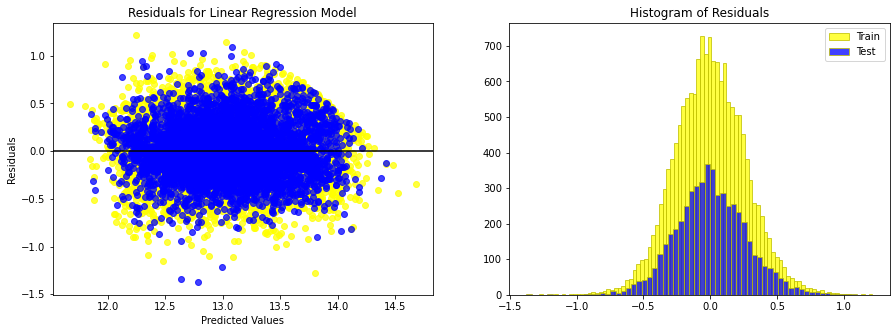

LinearRegression()

In [57]:
predictors = continuous + ohe_cols + logs
sk_linear_regression(df_ohe2, predictors, outcome, log=True)

### Analysis

In this model we seem to have taken a step back at our R score and hence only account for 70.5% of our data's variance. Our RMSE has increased as well meaning our data would have an error of around $110,558. Noticing the normalcy of the residuals however gives some peace in mind that the categorical variables were indeed not able to disturb the homoscedasticity. The stats model summary below will give us more details.

In [58]:
model = sm_linear_regression(df_ohe2, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     2103.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:42   Log-Likelihood:                -1632.2
No. Observations:               15879   AIC:                             3302.
Df Residuals:                   15860   BIC:                             3448.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -90.5938      2.285    -39.656      0.000     -95.072     -86.116
lat                   1.4494      0.016     90.591      0.000       1.418       1.481
long                 -0.2360      0.018    -13.201      0.000      -0.271      -0.201
Gra_Good              0.2497      0.007     34.747      0.000       0.236       0.264
Gra_Very Bad         -0.1205      0.008    -14.934      0.000      -0.136      -0.105
Con_Bad              -0.0969      0.025     -3.896      0.000      -0.146      -0.048
Con_Good              0.1126      0.005     22.842      0.000       0.103       0.122
Bed_Large            -0.0284      0.005     -5.301      0.000      -0.039      -0.018
Bed_Small             0.0903      0.007     12.251      0.000       0.076       0.105
Bat_High              0.0678      0.008      8.700      0.000       0.053       0.083
Bat_Med              -0.0219      0.007     -3.360      0.001      -0.035      -0.009
Bui_BIG               0.0581      0.014      4.028      0.000       0.030       0.086
Bui_MED               0.0156      0.006      2.536      0.011       0.004       0.028
wat_1.0               0.4640      0.032     14.633      0.000       0.402       0.526
Rec_True              0.0272      0.007      3.841      0.000       0.013       0.041
sqft_living_log       0.4776      0.011     44.904      0.000       0.457       0.498
sqft_lot_log          0.0357      0.006      5.660      0.000       0.023       0.048
sqft_living15_log     0.3109      0.011     28.769      0.000       0.290       0.332
sqft_lot15_log       -0.0576      0.007     -8.438      0.000      -0.071      -0.044
==============================================================================
Omnibus:                      101.368   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.001
Skew:                           0.067   Prob(JB):                     8.86e-32
Kurtosis:                       3.445   Cond. No.                     1.42e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bining and Plan of Action

From the summary the skewness and kurtosis haven't changed much but our R2 has been reduced to 0.705.
Finally, if we check the QQplot of the model the residuals are as normally distributed except on the lower end signifying some outliers or multicollinearity.

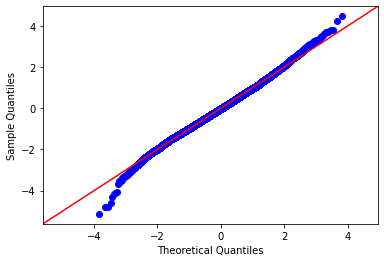

In [59]:
qqplot(model)

## Model #6: Variable Correlations

In a model like this, multicollinearity can be a huge problem because we want to know how each variable affects our outcome metric and to confirm that, we need to ensure that the variables are independent. First, we can examine the correlations between our variables using a heat map. Let's examine the continuous variables first:

<AxesSubplot:>

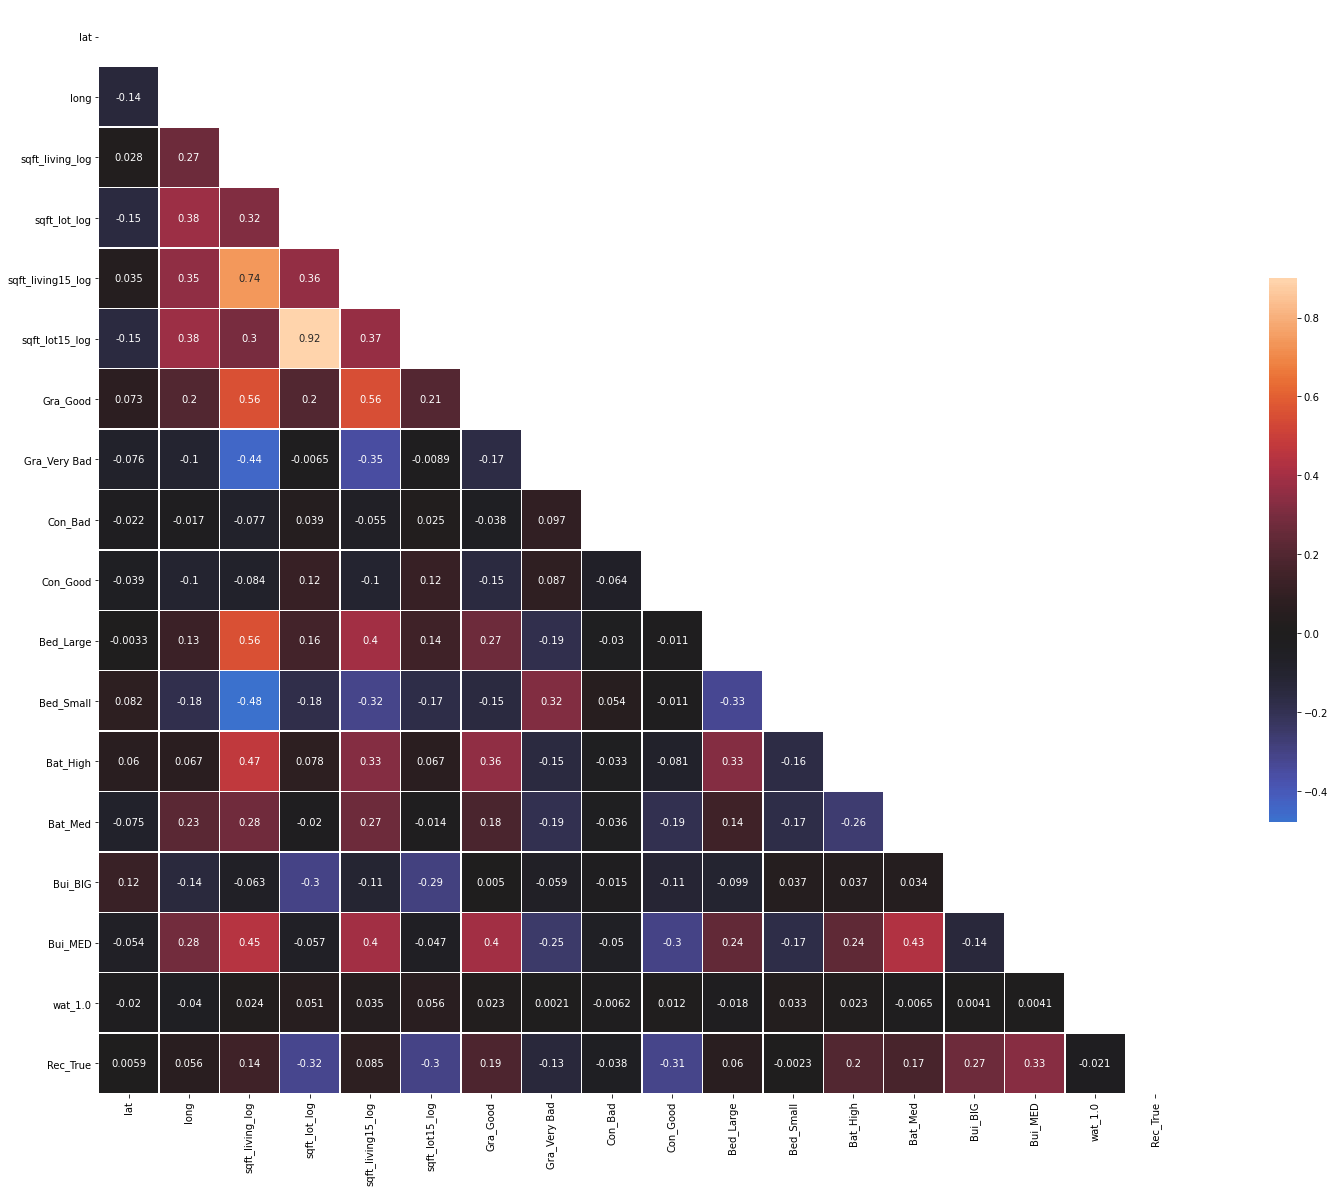

In [60]:
# Compute the correlation matrix
corr = df_ohe2[continuous+logs+ohe_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.abs(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30,20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Analysis


Any correlation coefficient greater than 0.70 could cause issues. We can see a few issues immediately, all of which make a reasonable amount of sense:

- sqft_lot_log vs. sqft_lot15_log = 0.92
- sqft_living_log vs. sqft_living15_log = 0.74

If we look at sqft_lot_log (a measure of the lot's square footage) vs. sqft_lot15_log (the mean of the square footage of 15 neighbors) it tracks that homes with large lots will be located near other homes with large lots.

It's reasonable then to drop some of these columns to help the model. We can drop both the sqft_living15_log and the sqft_lot15_log columns without losing any key information.

In [61]:
logs

['sqft_living_log', 'sqft_lot_log', 'sqft_living15_log', 'sqft_lot15_log']

In [62]:
for col in ['sqft_living15_log', 'sqft_lot15_log']:
    logs.remove(col)
print(logs)

['sqft_living_log', 'sqft_lot_log']


Training Scores:
R2: 0.6886365409890295
Root Mean Squared Error: 164358.06929466405
Mean Absolute Error: 112086.11533620044
---
Testing Scores:
R2: 0.6862572745782904
Root Mean Squared Error: 168376.31312905884
Mean Absolute Error: 112742.4656563802


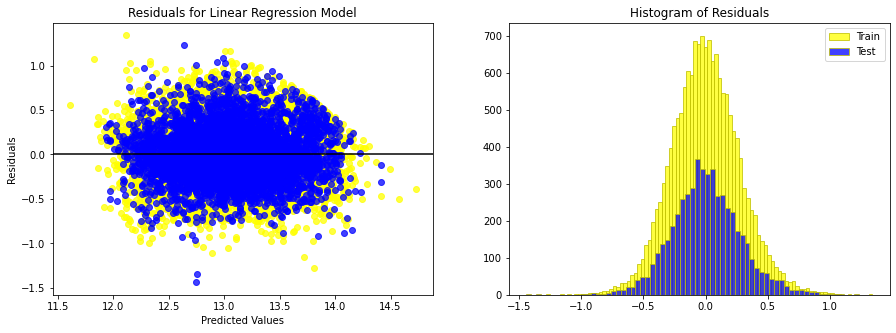

LinearRegression()

In [63]:
predictors = continuous + ohe_cols + logs
sk_linear_regression(df_ohe2, predictors, outcome, log=True)

In [64]:
model = sm_linear_regression(df_ohe2, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     2195.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:45   Log-Likelihood:                -2047.2
No. Observations:               15879   AIC:                             4128.
Df Residuals:                   15862   BIC:                             4259.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -83.0137      2.314    -35.882      0.000     -87.548     -78.479
lat                 1.4785      0.016     90.207      0.000       1.446       1.511
long               -0.1722      0.018     -9.517      0.000      -0.208      -0.137
Gra_Good            0.2947      0.007     41.132      0.000       0.281       0.309
Gra_Very Bad       -0.1433      0.008    -17.391      0.000      -0.159      -0.127
Con_Bad            -0.0923      0.026     -3.614      0.000      -0.142      -0.042
Con_Good            0.1082      0.005     21.402      0.000       0.098       0.118
Bed_Large          -0.0275      0.005     -5.009      0.000      -0.038      -0.017
Bed_Small           0.1026      0.008     13.582      0.000       0.088       0.117
Bat_High            0.0714      0.008      8.927      0.000       0.056       0.087
Bat_Med            -0.0073      0.007     -1.095      0.273      -0.020       0.006
Bui_BIG             0.0423      0.015      2.865      0.004       0.013       0.071
Bui_MED             0.0210      0.006      3.338      0.001       0.009       0.033
wat_1.0             0.4802      0.033     14.767      0.000       0.416       0.544
Rec_True            0.0222      0.007      3.059      0.002       0.008       0.036
sqft_living_log     0.6062      0.010     61.139      0.000       0.587       0.626
sqft_lot_log        0.0009      0.003      0.273      0.785      -0.005       0.007
==============================================================================
Omnibus:                      168.975   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.004
Skew:                           0.131   Prob(JB):                     4.64e-53
Kurtosis:                       3.543   Cond. No.                     1.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A quick check on our multicollinearity after removing the highly correlated features.

<AxesSubplot:>

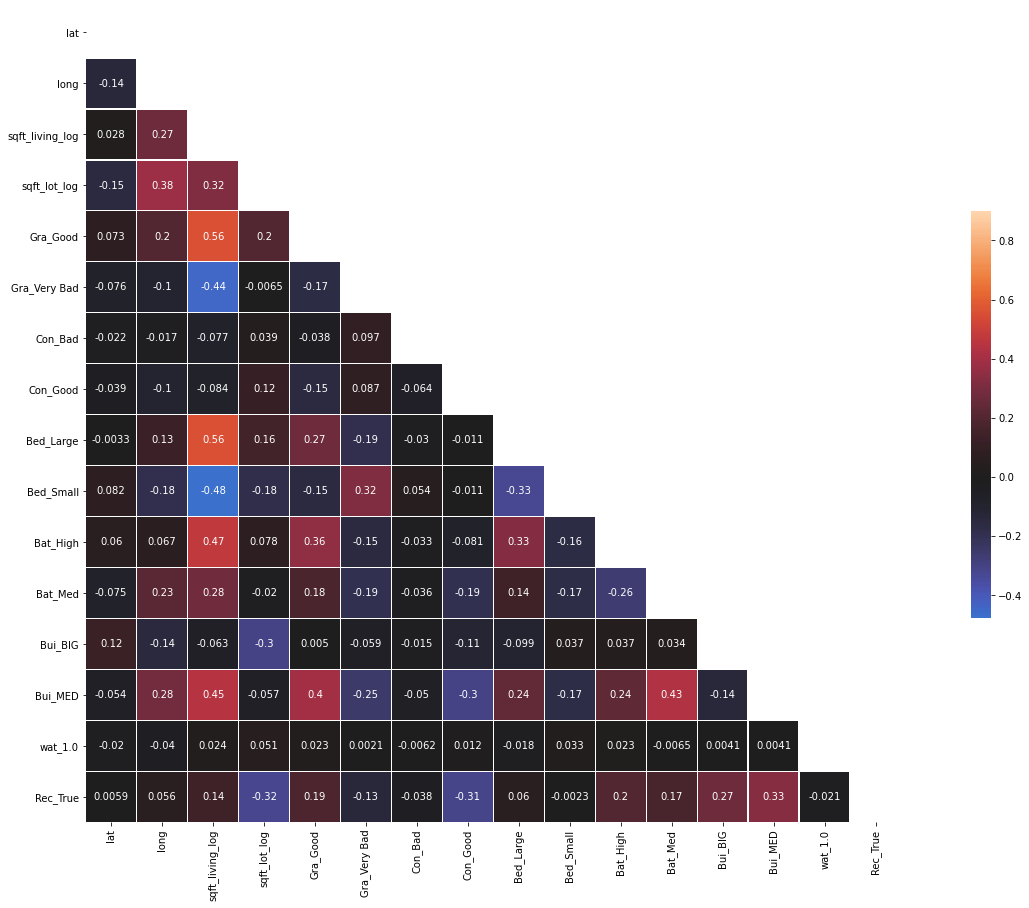

In [65]:
# Compute the correlation matrix
corr = df_ohe2[continuous+logs+ohe_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr.abs(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25,15))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.9, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

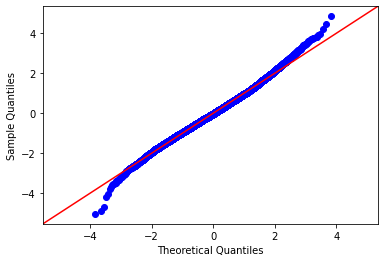

In [66]:
qqplot(model)

## Model #5: One Hot Encoding zipcodes

From the website 'gis-kingcounty.opendata.arcgis.com' I have loaded the ```all_zipcodes.csv``` file and extracted the zipcodes and cities in our data. In this step I will see how one hot encoding our zipcodes would affect our model and observe by how much it would alter our prices.

In [67]:
all_zipcodes = pd.read_csv('all_zipcodes.csv')
all_zipcodes.head()

,X,Y,OBJECTID,ZIP,ZIPCODE,COUNTY,ZIP_TYPE,PREFERRED_CITY,FEATURE_SOURCE
0,-122.584242,47.855762,1,98364,98364,35.0,PO Box,PORT GAMBLE,Placed Point
1,-122.202454,47.620601,2,98009,98009,33.0,PO Box,BELLEVUE,Placed Point
2,-122.186795,47.611861,3,98015,98015,33.0,PO Box,BELLEVUE,Placed Point
3,-121.972726,47.419935,4,98025,98025,33.0,PO Box,HOBART,Placed Point
4,-122.234416,47.380592,5,98035,98035,33.0,PO Box,KENT,Placed Point


In [68]:
zipcode_dict = {
    98178: 'Seattle',
    98125: 'Seattle',
    98028: 'Kenmore',
    98136: 'Seattle',
    98074: 'Sammamish',
    98053: 'Redmond',
    98003: 'Federal Way',
    98198: 'S Seattle',
    98146: 'S Seattle',
    98038: 'Maple Valley',
    98007: 'Bellevue',
    98115: 'Seattle',
    98107: 'Seattle',
    98126: 'Seattle',
    98019: 'Duvall',
    98103: 'Seattle',
    98002: 'Auburn',
    98133: 'Seattle',
    98040: 'Mercer',
    98092: 'Auburn',
    98030: 'Kent',
    98119: 'Seattle',
    98112: 'Seattle',
    98052: 'Redmond',
    98027: 'Issaquah',
    98117: 'Seattle',
    98058: 'Renton',
    98001: 'Auburn', 
    98056: 'Renton', 
    98166: 'S Seattle', 
    98023: 'Federal Way', 
    98070: 'Vashon', 
    98148: 'Seattle', 
    98105: 'Seattle', 
    98042: 'Kent', 
    98008: 'Bellevue',
    98059: 'Renton', 
    98122: 'Seattle', 
    98144: 'Seattle', 
    98004: 'Bellevue', 
    98005: 'Bellevue', 
    98034: 'Kirkland', 
    98075: 'Sammamish', 
    98116: 'Seattle', 
    98010: 'Black Diamond',
    98118: 'Seattle', 
    98199: 'Seattle', 
    98032: 'Kent', 
    98045: 'North Bend', 
    98102: 'Seattle', 
    98077: 'Woodinville', 
    98108: 'Seattle', 
    98168: 'S Seattle', 
    98177: 'N Seattle',
    98065: 'Snoqualmie', 
    98029: 'Issaquah', 
    98006: 'Bellevue', 
    98109: 'Seattle', 
    98022: 'Enumclaw', 
    98033: 'Kirkland', 
    98155: 'N Seattle', 
    98024: 'Fall City', 
    98011: 'Bothell',
    98031: 'Kent', 
    98106: 'Seattle', 
    98072: 'Woodinville', 
    98188: 'S Seattle', 
    98014: 'Carnation', 
    98055: 'Renton', 
    98039: 'Medina'
}

In [69]:
len(zipcode_dict)

70

Before moving on to the next step and creating dummies for all zipcodes, I will first group the zipcodes by city and there create dummies for those cities.

In [70]:
df_ohe2['City'] = df_ohe2.zipcode.map(lambda x: zipcode_dict[x])
print('Number of Cities:', df_ohe2.City.nunique())
df_ohe2.City.value_counts()

Number of Cities: 26


Seattle          6905
Renton           1587
Bellevue         1321
S Seattle        1205
Kent             1196
Redmond           971
Kirkland          956
Auburn            903
Sammamish         789
Federal Way       775
Issaquah          725
N Seattle         689
Maple Valley      586
Woodinville       467
Snoqualmie        305
Kenmore           281
Mercer            253
Enumclaw          230
North Bend        218
Bothell           194
Duvall            188
Carnation         119
Vashon            111
Black Diamond      99
Fall City          77
Medina             22
Name: City, dtype: int64

In [71]:
#create dummies for all cities.
ohe_City = pd.get_dummies(df_ohe2.City, prefix='C', drop_first=True)

City_cols = ohe_City.columns.to_list()

df_ohe3 = pd.concat([df_ohe2, ohe_City], axis=1)

In [72]:
City_cols

['C_Bellevue',
 'C_Black Diamond',
 'C_Bothell',
 'C_Carnation',
 'C_Duvall',
 'C_Enumclaw',
 'C_Fall City',
 'C_Federal Way',
 'C_Issaquah',
 'C_Kenmore',
 'C_Kent',
 'C_Kirkland',
 'C_Maple Valley',
 'C_Medina',
 'C_Mercer',
 'C_N Seattle',
 'C_North Bend',
 'C_Redmond',
 'C_Renton',
 'C_S Seattle',
 'C_Sammamish',
 'C_Seattle',
 'C_Snoqualmie',
 'C_Vashon',
 'C_Woodinville']

In [73]:
df_ohe3.columns

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'month', 'year', 'waterfront', 'sqft_living_log', 'sqft_lot_log',
       'sqft_living15_log', 'sqft_lot15_log', 'Recent_Const', 'Building',
       'Baths', 'Beds', 'Cond', 'Grade', 'Gra_Good', 'Gra_Very Bad', 'Con_Bad',
       'Con_Good', 'Bed_Large', 'Bed_Small', 'Bat_High', 'Bat_Med', 'Bui_BIG',
       'Bui_MED', 'wat_1.0', 'Rec_True', 'City', 'C_Bellevue',
       'C_Black Diamond', 'C_Bothell', 'C_Carnation', 'C_Duvall', 'C_Enumclaw',
       'C_Fall City', 'C_Federal Way', 'C_Issaquah', 'C_Kenmore', 'C_Kent',
       'C_Kirkland', 'C_Maple Valley', 'C_Medina', 'C_Mercer', 'C_N Seattle',
       'C_North Bend', 'C_Redmond', 'C_Renton', 'C_S Seattle', 'C_Sammamish',
       'C_Seattle', 'C_Snoqualmie', 'C_Vashon', 'C_Woodinville'],
      dtype='object')

In [74]:
logs

['sqft_living_log', 'sqft_lot_log']

In [75]:
ohe_cols

['Gra_Good',
 'Gra_Very Bad',
 'Con_Bad',
 'Con_Good',
 'Bed_Large',
 'Bed_Small',
 'Bat_High',
 'Bat_Med',
 'Bui_BIG',
 'Bui_MED',
 'wat_1.0',
 'Rec_True']

In [76]:
continuous

['lat', 'long']

Training Scores:
R2: 0.7812799368703713
Root Mean Squared Error: 136207.6225426104
Mean Absolute Error: 89886.10239432662
---
Testing Scores:
R2: 0.7756540182680476
Root Mean Squared Error: 141522.61925808096
Mean Absolute Error: 91595.18618943437


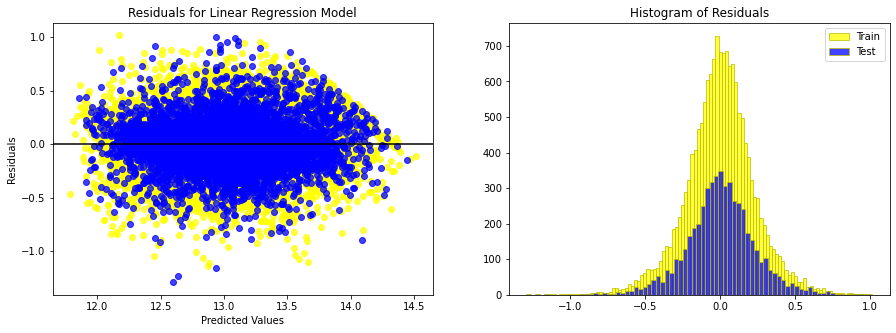

LinearRegression()

In [77]:
predictors = continuous + logs + ohe_cols + City_cols
sk_linear_regression(df_ohe3, predictors, outcome, log=True)

### Analysis

Ok, our best fit so far would have to be this model. There is a visible improvement in our R score and now our model can account for 77.7% of variance for our data. Noticable the RMSE has taken a big step forward signifying our data now would have an error of $91,500, not very accurate but definitely better. Let's take a look at the model summary below for some more details.

In [78]:
model = sm_linear_regression(df_ohe3, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     1370.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:48   Log-Likelihood:                 707.49
No. Observations:               15879   AIC:                            -1331.
Df Residuals:                   15837   BIC:                            -1009.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -147.8550      5.632    -26.252      0.000    -158.894    -136.815
lat                 1.2476      0.040     31.151      0.000       1.169       1.326
long               -0.7901      0.045    -17.525      0.000      -0.878      -0.702
sqft_living_log     0.5627      0.008     66.991      0.000       0.546       0.579
sqft_lot_log        0.0535      0.003     17.749      0.000       0.048       0.059
Gra_Good            0.2329      0.006     37.757      0.000       0.221       0.245
Gra_Very Bad       -0.1267      0.007    -18.043      0.000      -0.140      -0.113
Con_Bad            -0.1193      0.022     -5.545      0.000      -0.161      -0.077
Con_Good            0.0750      0.004     17.344      0.000       0.067       0.084
Bed_Large          -0.0313      0.005     -6.757      0.000      -0.040      -0.022
Bed_Small           0.0612      0.006      9.533      0.000       0.049       0.074
Bat_High            0.0630      0.007      9.344      0.000       0.050       0.076
Bat_Med             0.0189      0.006      3.336      0.001       0.008       0.030
Bui_BIG             0.0089      0.013      0.707      0.479      -0.016       0.034
Bui_MED             0.0438      0.005      8.175      0.000       0.033       0.054
wat_1.0             0.4908      0.028     17.789      0.000       0.437       0.545
Rec_True            0.0433      0.006      7.032      0.000       0.031       0.055
C_Bellevue          0.4604      0.017     27.355      0.000       0.427       0.493
C_Black Diamond     0.3469      0.031     11.317      0.000       0.287       0.407
C_Bothell          -0.0916      0.028     -3.274      0.001      -0.146      -0.037
C_Carnation         0.1088      0.035      3.084      0.002       0.040       0.178
C_Duvall           -0.0225      0.030     -0.743      0.458      -0.082       0.037
C_Enumclaw          0.3818      0.022     17.391      0.000       0.339       0.425
C_Fall City         0.4023      0.037     10.855      0.000       0.330       0.475
C_Federal Way      -0.0985      0.014     -6.888      0.000      -0.126      -0.070
C_Issaquah          0.4212      0.019     22.255      0.000       0.384       0.458
C_Kenmore          -0.1602      0.026     -6.212      0.000      -0.211      -0.110
C_Kent              0.0047      0.012      0.380      0.704      -0.020       0.029
C_Kirkland          0.1751      0.020      8.640      0.000       0.135       0.215
C_Maple Valley      0.2298      0.017     13.661      0.000       0.197       0.263
C_Medina            0.8730      0.060     14.546      0.000       0.755       0.991
C_Mercer            0.6044      0.021     28.130      0.000       0.562       0.646
C_N Seattle        -0.1120      0.022     -4.985      0.000      -0.156      -0.068
C_North Bend        0.4882      0.030     16.246      0.000

### One Hot Encoding Analysis and Plan of Action

Our R2 looks good for this model but the most concerning parts would be the p-values of some of the variables having more than 0.05. This could be caused by those variables actually having no influence on the price or it could also be a sign of multicollinearity. If we notice our confidence interval for those features, we see that it bounces between negative and positive values. This could mean that since the values of those intervals are close to zero then there is a higher chance that those features have no effect on the price or that it may have been caused purely by chance.

In this next step I will drop those features with high p-values and see how our model performs.



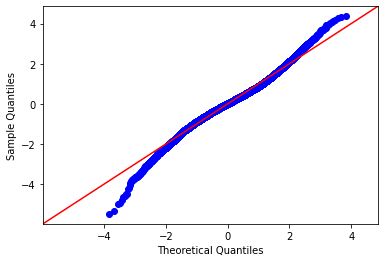

In [79]:
qqplot(model)

Removing 'Bui_BIG' since it has a p-value of more than 0.05 and its coefficient doesn't seem to make sense being that it shows the price to decrease as the building Floors increase.

In [80]:
ohe_cols

['Gra_Good',
 'Gra_Very Bad',
 'Con_Bad',
 'Con_Good',
 'Bed_Large',
 'Bed_Small',
 'Bat_High',
 'Bat_Med',
 'Bui_BIG',
 'Bui_MED',
 'wat_1.0',
 'Rec_True']

In [81]:
ohe_cols = ['Gra_Good',
 'Gra_Very Bad',
 'Con_Bad',
 'Con_Good',
 'Bed_Large',
 'Bed_Small',
 'Bat_High',
 'Bat_Med',
 'Bui_MED',
 'wat_1.0',
 'Rec_True']

In [82]:
City_cols

['C_Bellevue',
 'C_Black Diamond',
 'C_Bothell',
 'C_Carnation',
 'C_Duvall',
 'C_Enumclaw',
 'C_Fall City',
 'C_Federal Way',
 'C_Issaquah',
 'C_Kenmore',
 'C_Kent',
 'C_Kirkland',
 'C_Maple Valley',
 'C_Medina',
 'C_Mercer',
 'C_N Seattle',
 'C_North Bend',
 'C_Redmond',
 'C_Renton',
 'C_S Seattle',
 'C_Sammamish',
 'C_Seattle',
 'C_Snoqualmie',
 'C_Vashon',
 'C_Woodinville']

In [83]:
#dropping cities with p-values higher than 0.05 (C_Woodinville, C_Kent, C_Vashon,C_Duvall )
City_cols = ['C_Bellevue',
 'C_Black Diamond',
 'C_Bothell',
 'C_Carnation',
 'C_Enumclaw',
 'C_Fall City',
 'C_Federal Way',
 'C_Issaquah',
 'C_Kenmore',
 'C_Kirkland',
 'C_Maple Valley',
 'C_Medina',
 'C_Mercer',
 'C_N Seattle',
 'C_North Bend',
 'C_Redmond',
 'C_Renton',
 'C_S Seattle',
 'C_Sammamish',
 'C_Seattle',
 'C_Snoqualmie']

Training Scores:
R2: 0.7812419310819883
Root Mean Squared Error: 136263.11573581185
Mean Absolute Error: 89909.88807173615
---
Testing Scores:
R2: 0.7756560770567609
Root Mean Squared Error: 141559.0906858667
Mean Absolute Error: 91627.55935834172


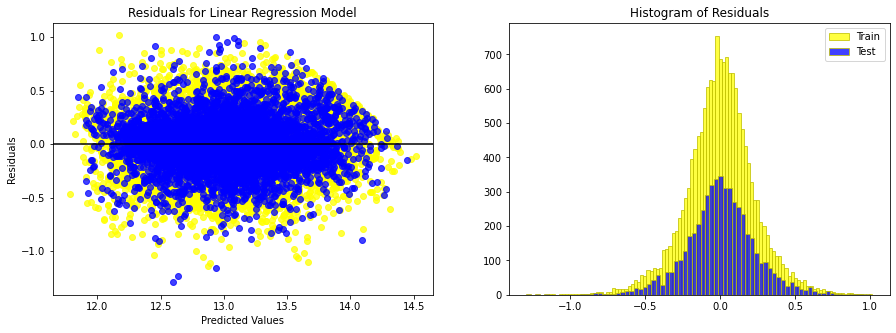

LinearRegression()

In [84]:
predictors = continuous + logs + ohe_cols + City_cols
sk_linear_regression(df_ohe3, predictors, outcome, log=True)

In [85]:
model = sm_linear_regression(df_ohe3, predictors, outcome, log=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     1561.
Date:                Tue, 08 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:56:49   Log-Likelihood:                 705.97
No. Observations:               15879   AIC:                            -1338.
Df Residuals:                   15842   BIC:                            -1054.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -150.8226      4.902    -30.766      0.000    -160.432    -141.214
lat                 1.2527      0.024     51.156      0.000       1.205       1.301
long               -0.8124      0.037    -22.240      0.000      -0.884      -0.741
sqft_living_log     0.5626      0.008     67.013      0.000       0.546       0.579
sqft_lot_log        0.0535      0.003     18.584      0.000       0.048       0.059
Gra_Good            0.2336      0.006     38.069      0.000       0.222       0.246
Gra_Very Bad       -0.1271      0.007    -18.152      0.000      -0.141      -0.113
Con_Bad            -0.1195      0.022     -5.555      0.000      -0.162      -0.077
Con_Good            0.0749      0.004     17.387      0.000       0.066       0.083
Bed_Large          -0.0316      0.005     -6.838      0.000      -0.041      -0.023
Bed_Small           0.0611      0.006      9.535      0.000       0.049       0.074
Bat_High            0.0635      0.007      9.459      0.000       0.050       0.077
Bat_Med             0.0194      0.006      3.465      0.001       0.008       0.030
Bui_MED             0.0427      0.005      8.363      0.000       0.033       0.053
wat_1.0             0.4921      0.027     17.947      0.000       0.438       0.546
Rec_True            0.0440      0.006      7.302      0.000       0.032       0.056
C_Bellevue          0.4567      0.010     46.653      0.000       0.438       0.476
C_Black Diamond     0.3483      0.029     12.021      0.000       0.291       0.405
C_Bothell          -0.0970      0.022     -4.490      0.000      -0.139      -0.055
C_Carnation         0.1116      0.028      3.993      0.000       0.057       0.166
C_Enumclaw          0.3837      0.020     18.841      0.000       0.344       0.424
C_Fall City         0.4045      0.033     12.335      0.000       0.340       0.469
C_Federal Way      -0.1048      0.013     -8.319      0.000      -0.130      -0.080
C_Issaquah          0.4209      0.012     34.367      0.000       0.397       0.445
C_Kenmore          -0.1667      0.019     -8.661      0.000      -0.204      -0.129
C_Kirkland          0.1699      0.012     13.967      0.000       0.146       0.194
C_Maple Valley      0.2302      0.013     17.188      0.000       0.204       0.256
C_Medina            0.8673      0.058     14.839      0.000       0.753       0.982
C_Mercer            0.5992      0.018     33.457      0.000       0.564       0.634
C_N Seattle        -0.1203      0.016     -7.673      0.000      -0.151      -0.090
C_North Bend        0.4941      0.024     20.749      0.000       0.447       0.541
C_Redmond           0.2583      0.012     22.122      0.000       0.235       0.281
C_Renton            0.0827      0.008      9.739      0.000       0.066       0.099
C_S Seattle        -0.0868      0.011     -7.841      0.000

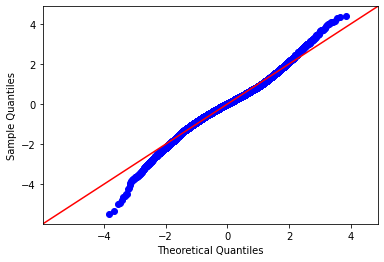

In [86]:
qqplot(model)

Finally our model now looks like a good fit. We can now account for 78% of our data's variance.  Our data would have an error of around $91,519 which is a similar to our previous model.

# Conclusion

## Conclusion and Recomendation

As we have seen, in our final model, we could account for about 78% of the variance in the housing price data. Our mean absolute error for the model is around $91,627, which is not ideal for accurately predicting a sale price. That said, based on this model, we know that the five most influential factors in property sale price with their coefficients are:

- **Latitude**:(1.25) 
    (How far North the property is) A unit increase in latitude increases the price of a property by 1.25 units.
- **Built in Medina**: (0.87)
- **Built in Mercer**:(0.6) 
    A property in Medina would be worth (0.87-0.6) units more than a property in Mercer.
- **Square Footage of Living**: 
    a 1% increase would account for 0.61% increase in price
- **Waterfront View**: (0.49) 
    A property's price with waterfront would be 0.49 units higher than if it didn't have waterfront.  


1. Adding square footage to a property can add significant value to a house.
2. Direct buyers with higher budget and priority of living area to invest on properties towards the Northern region of Seattle. 
3. Engage only in transaction of  homes with Condition value of (4-5).


The model can be used to predict house price although the model is not amazingly accurate. Still the results can be used for understanding the features of a property's relationship to the market. The models here focus on isolating factors for accurate coefficients rather than on precise prediction. 

# Areas of Further Study

This model has a lot of room for improvement. Other areas to explore in this data for the Real Estate agency are:

- Discover how sqft_basement for a given Lot area would play a role  
  in the sales price. 
- Determine the value of different types of expansions (Bedroom, Bathroom) and 
  investigate how that affects the value of a house.
- Identify areas of Seattle where housing prices are increasing and possibly predict which neighborhoods will be ideal for       settlement  in the future.  
- Improve the model with more data over the years after 2015 and observe if there is any change in the trend of the major   factors.